<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_1_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('_mpl-gallery')

In [8]:
url = 'https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv'
df = pd.read_csv(url)

# We can remove "year", "month" and "day" columns,
# since we did no time series analysis today...
# "VG" is removed, we do not have any info about
df = df.drop(['VG', 'year', 'month', 'day'], axis=1)

# Information about our data set
print('Number of Observations (N): ', df.shape[0])
print('Number of Predictor Variables (D): ', df.shape[1])

df.head()
print(df['COD'].describe())
print(df['BOD'].describe())

Number of Observations (N):  1382
Number of Predictor Variables (D):  16
count    1382.000000
mean      845.960434
std       145.416540
min       360.000000
25%       751.250000
50%       845.000000
75%       920.000000
max      1700.000000
Name: COD, dtype: float64
count    1382.000000
mean      382.061708
std        85.996012
min       140.000000
25%       330.000000
50%       360.000000
75%       422.980000
max       850.000000
Name: BOD, dtype: float64


#**Classes**

Como indicadores de economia/deseperdicio durante o tratamento, utilizaremos as métricas COD e BOD, que respectivamente significam Chemical Oxygen Demand (mg/L) e Biological Oxygen Demand (mg/L).

Dessa forma, podemos dividir o intervalo desses indicadores em n partes, utilizando-as como classificação.

A Chemical Oxygen Demand(COD), indica a quantidade de oxigênio utilizado durante a reação quimica para consumir contaminantes presentes. \
Já a Biological Oxygen Demand(BOD), é a unidade de medida utilizada para determinar a quantidade de oxigênio utilizado por organismos biológicos aeróbicos. \
Com os dois indicativos construiremos classes formadas da combinação dos dois intervalos criados pela média de COD e de BOD. \
Iremos dividir os nossos dados em 3 intervalos para cada preditor.\
COD:\
Baixo: 360 - 700 , Medio: 701 - 1200 ; Alto : 1201 - 1700\
BOD:\
Baixo 140 - 300 ; Medio: 301 - 600: ; Alto : 601 - 850\
Tipo1 : Baixo - Baixo ; Tipo 2 : Baix - Medio ; Tipo 3 Baixo - Alto\
Tipo 4 : Medio - Baixo ; Tipo 5 : Medio - Medio ; Tipo 6 Medio - Alto\
Tipo 7 : Alto - Baixo ; Tipo 8 : Alto - Medio ; Tipo 9 Alto - Alto;

In [29]:
df_cod_baixo = df[(df['COD'] >=360) & (df['COD'] <= 700)]
df_cod_medio = df[(df['COD'] >=701) & (df['COD'] <= 1200)]
df_cod_alto = df[(df['COD'] >=1201) & (df['COD'] <= 1700)]

df_bod_baixo = df[(df['BOD'] >=140) & (df['BOD'] <= 300)]
df_bod_medio = df[(df['BOD'] >=301) & (df['BOD'] <= 600)]
df_bod_alto = df[(df['BOD'] >=601) & (df['BOD'] <= 850)]


tipo1 = pd.merge(df_cod_baixo, df_bod_baixo, how='inner')
tipo2 = pd.merge(df_cod_baixo, df_bod_medio, how='inner')
tipo3 = pd.merge(df_cod_baixo, df_bod_alto, how='inner')

tipo4 = pd.merge(df_cod_medio, df_bod_baixo, how='inner')
tipo5 = pd.merge(df_cod_medio, df_bod_medio, how='inner')
tipo6 = pd.merge(df_cod_medio, df_bod_alto, how='inner')

tipo7 = pd.merge(df_cod_alto, df_bod_baixo, how='inner')
tipo8 = pd.merge(df_cod_alto, df_bod_medio, how='inner')
tipo9 = pd.merge(df_cod_alto, df_bod_alto, how='inner')

tipos = [tipo1, tipo2, tipo3, tipo4, tipo5, tipo6, tipo7, tipo8, tipo9]
for tipos in tipos:
  print(tipos)


    avg_outflow  avg_inflow  total_grid    Am    BOD    COD      TN     T  \
0         3.833       3.763      193509  43.0  295.0  590.0  59.548  33.9   
1         2.940       3.642      204062  29.0  286.5  573.0  54.630  27.2   
2         3.014       3.424      277587  35.0  290.0  580.0  55.946   9.2   
3         3.275       3.309      311573  37.0  255.0  510.0  57.990   7.7   
4         3.011       3.331      305095  49.0  250.0  500.0  58.526   8.9   
..          ...         ...         ...   ...    ...    ...     ...   ...   
66        5.392       4.930      328307  24.0  200.0  560.0  53.295   9.1   
67        4.582       4.802      339074  24.0  260.0  620.0  57.086  10.9   
68        4.875       5.346      353157  28.0  280.0  680.0  58.769   6.6   
69        4.846       4.219      343734  19.0  170.0  640.0  59.797  10.6   
70        5.882       5.510      293446  40.0  250.0  700.0  60.671   7.6   

      TM    Tm  SLP   H    PP    VV     V    VM  
0   43.1  23.7  0.0  24  

,name,mean,standard_deviation,skewness
1,avg_outflow,3.930608,1.228778,0.380545
2,avg_inflow,4.506338,1.439583,3.751865
3,total_grid,275159.089001,44640.533689,-0.148416
4,Am,39.222302,7.761598,0.310626
5,BOD,382.061708,85.996012,1.234594
6,COD,845.960434,145.416540,0.743344
7,TN,62.740752,3.571035,-0.256672
8,T,15.036686,5.398491,0.552359
9,TM,20.530897,7.096760,0.485291
10,Tm,10.037337,4.656887,0.498749


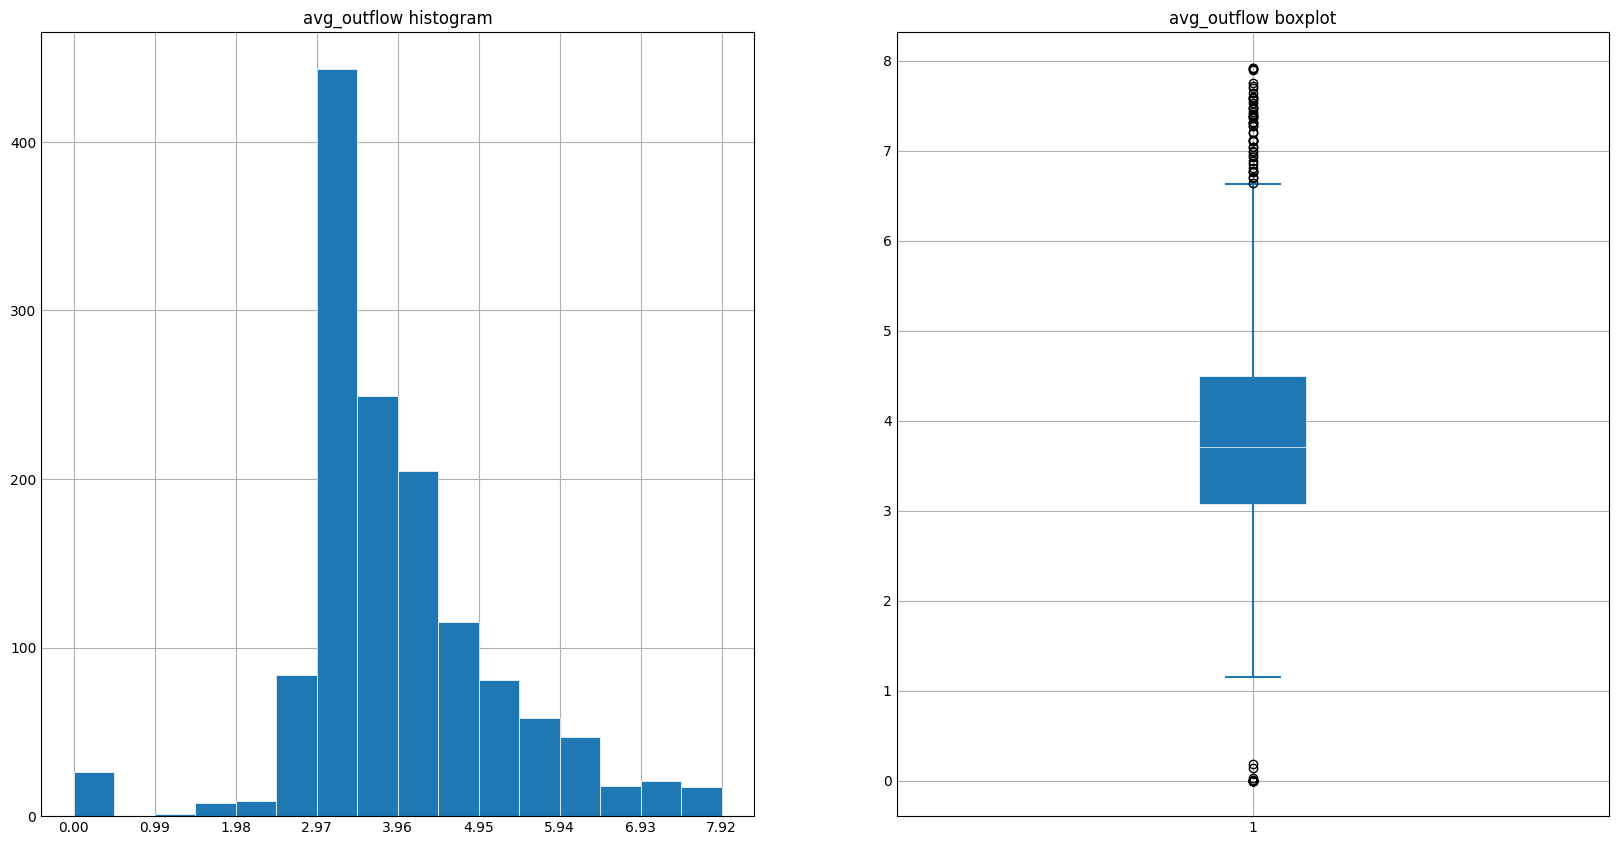

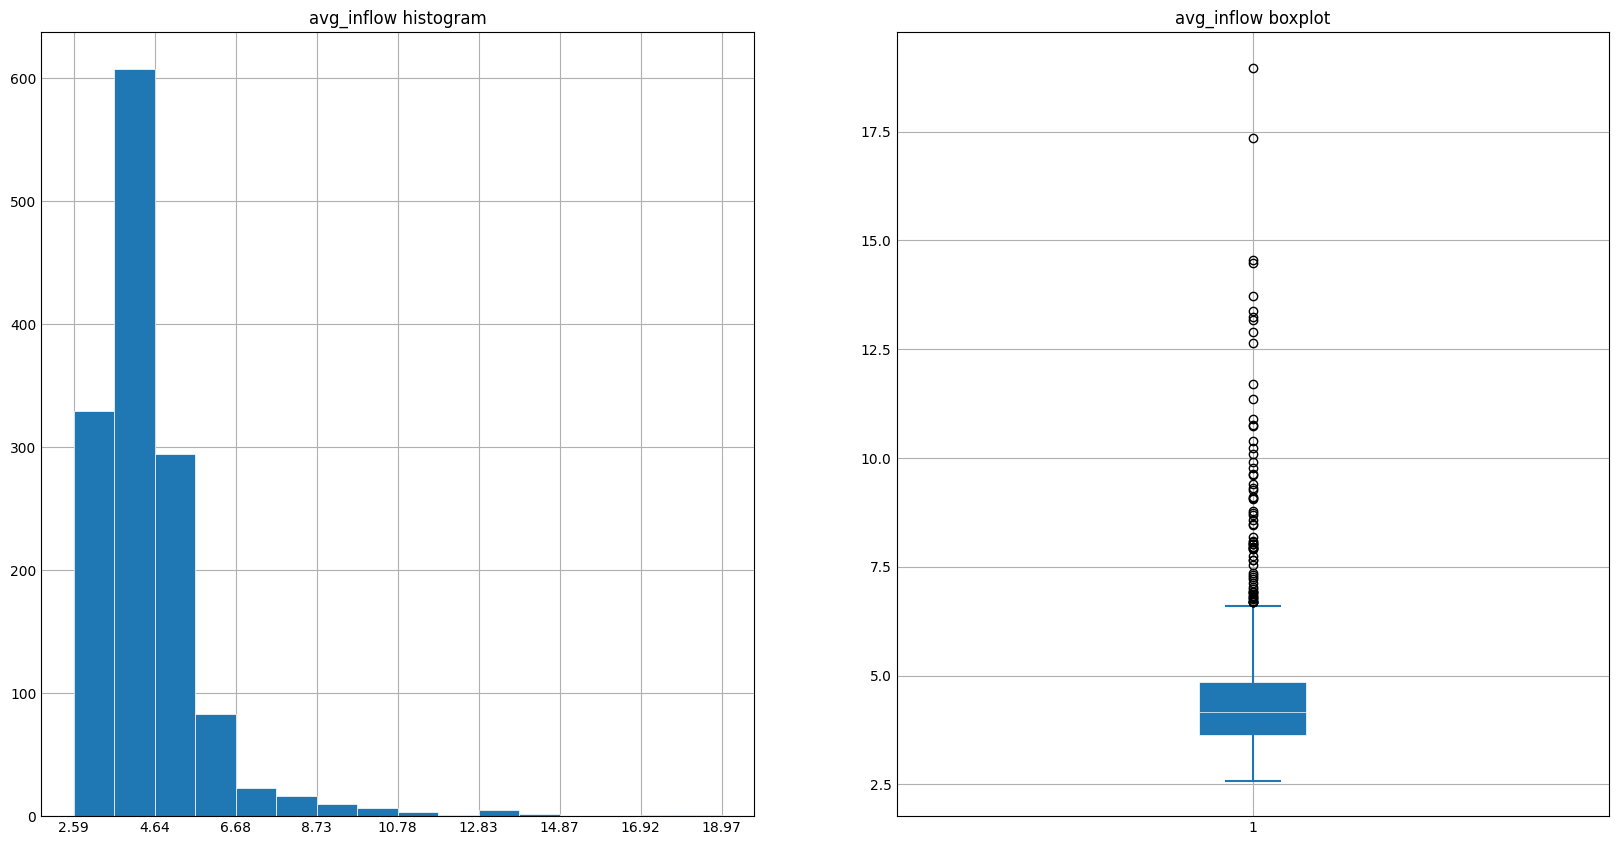

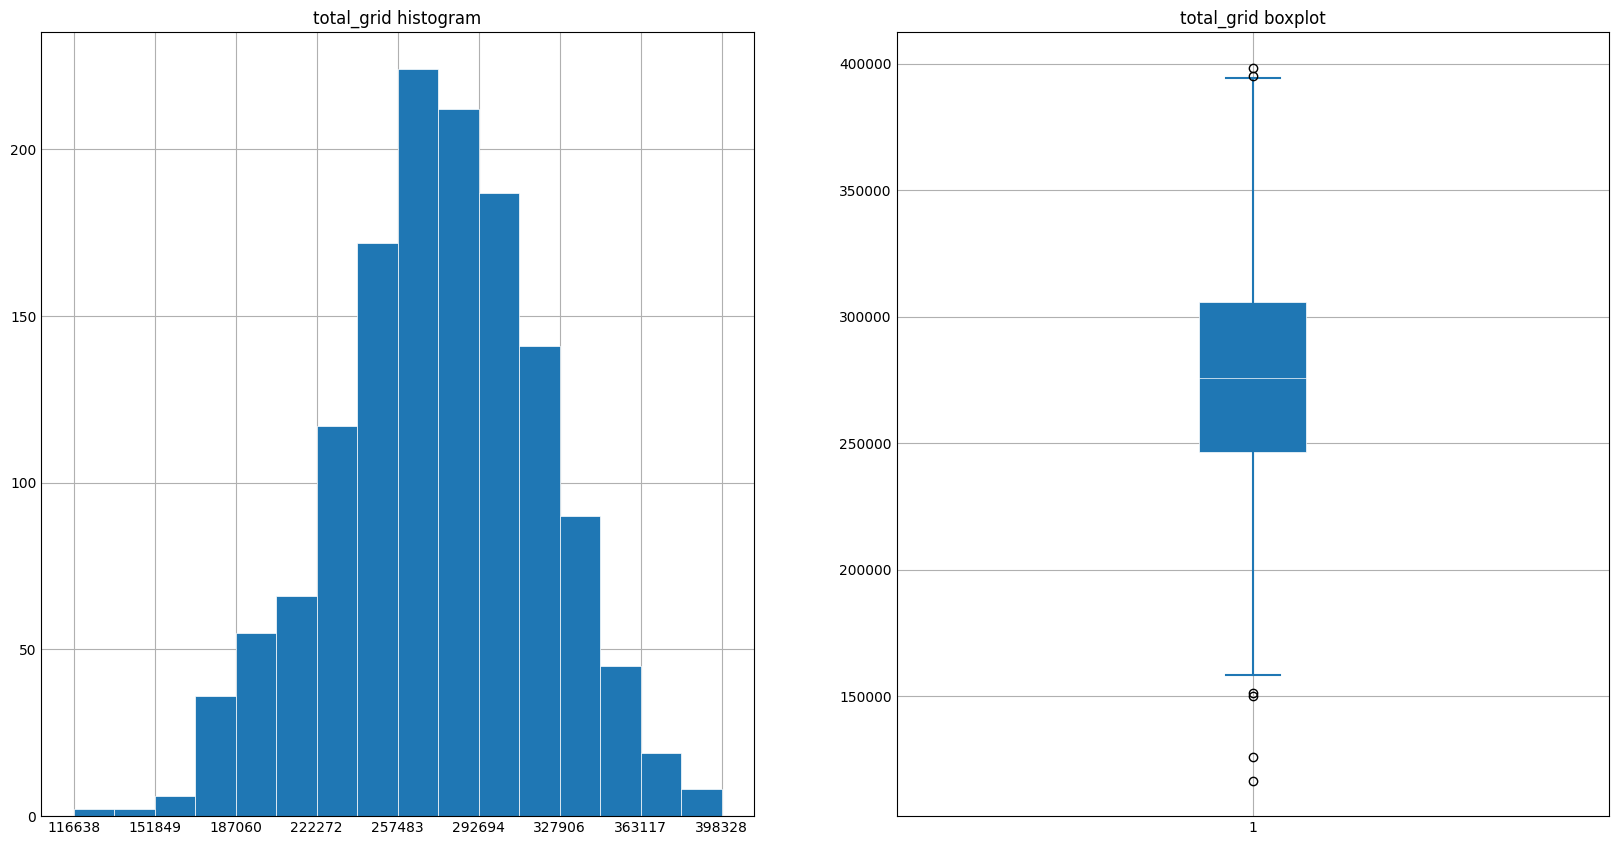

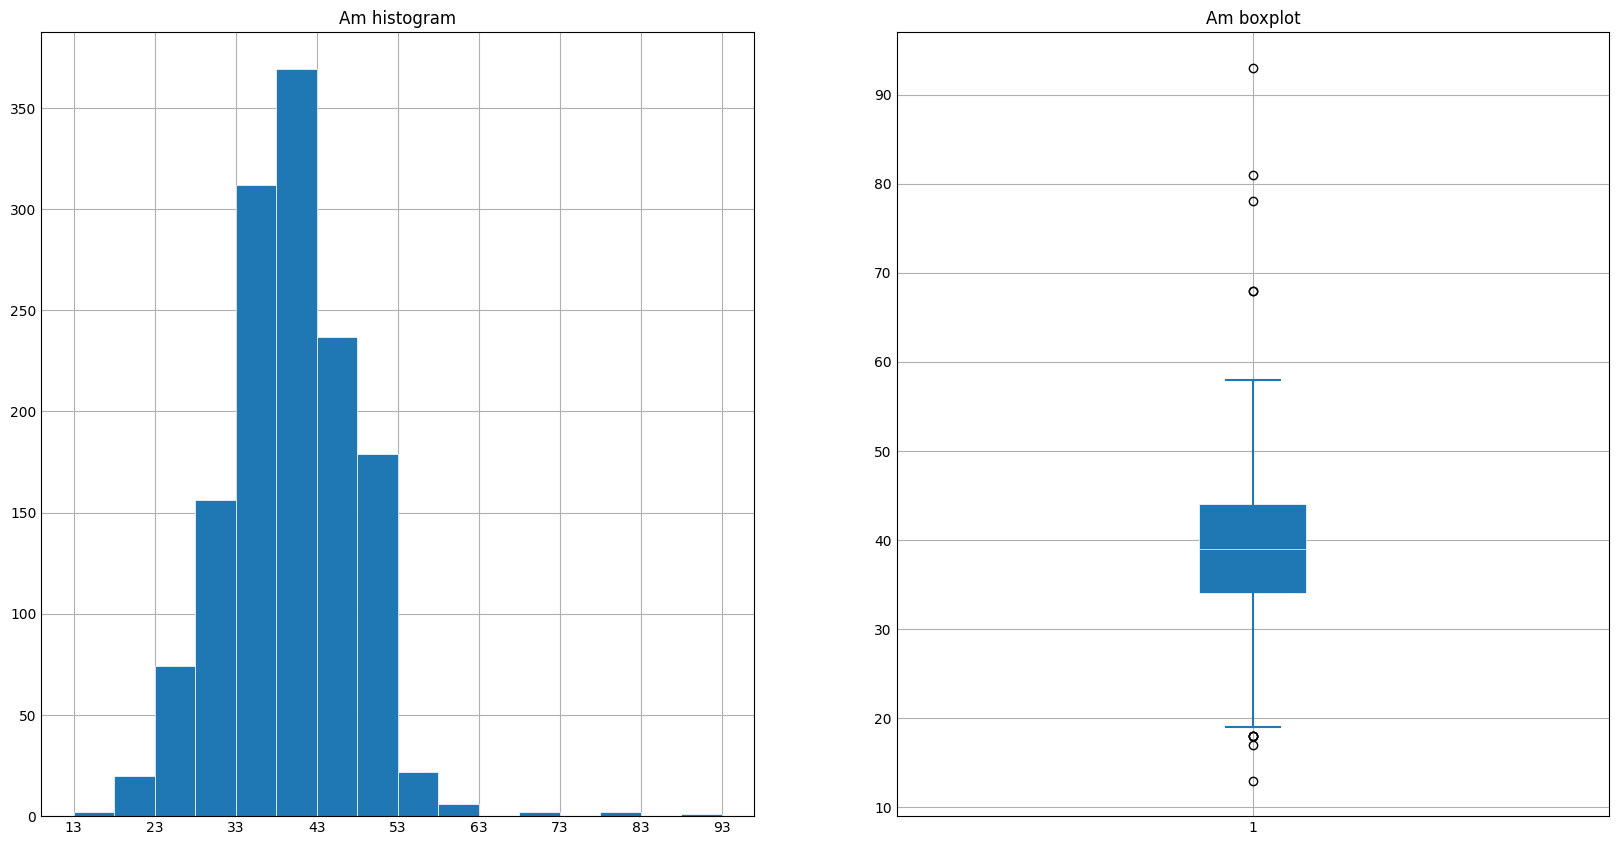

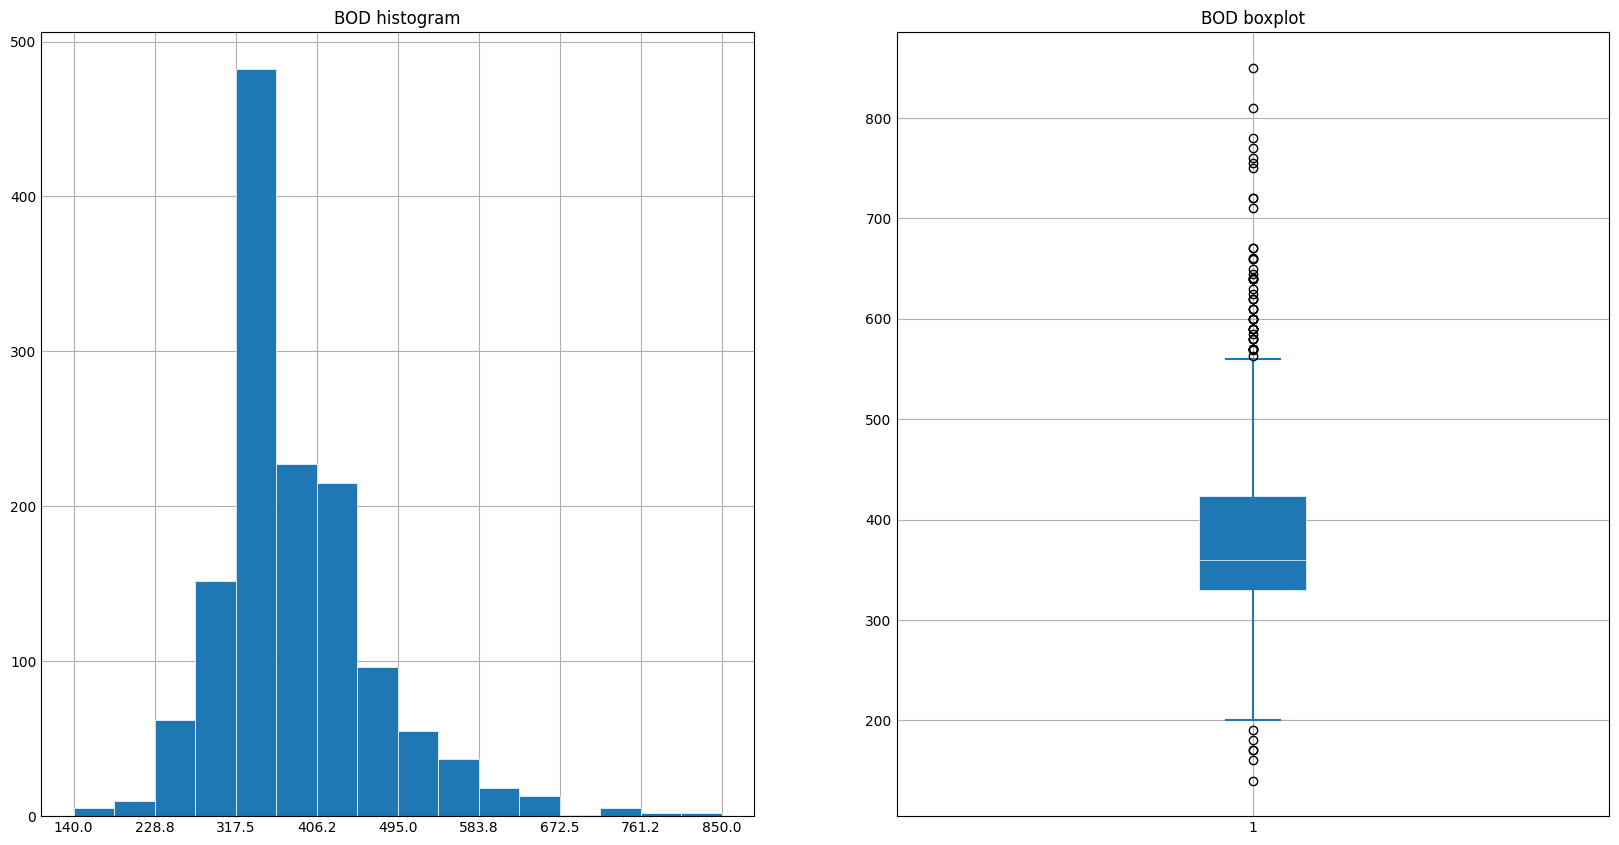

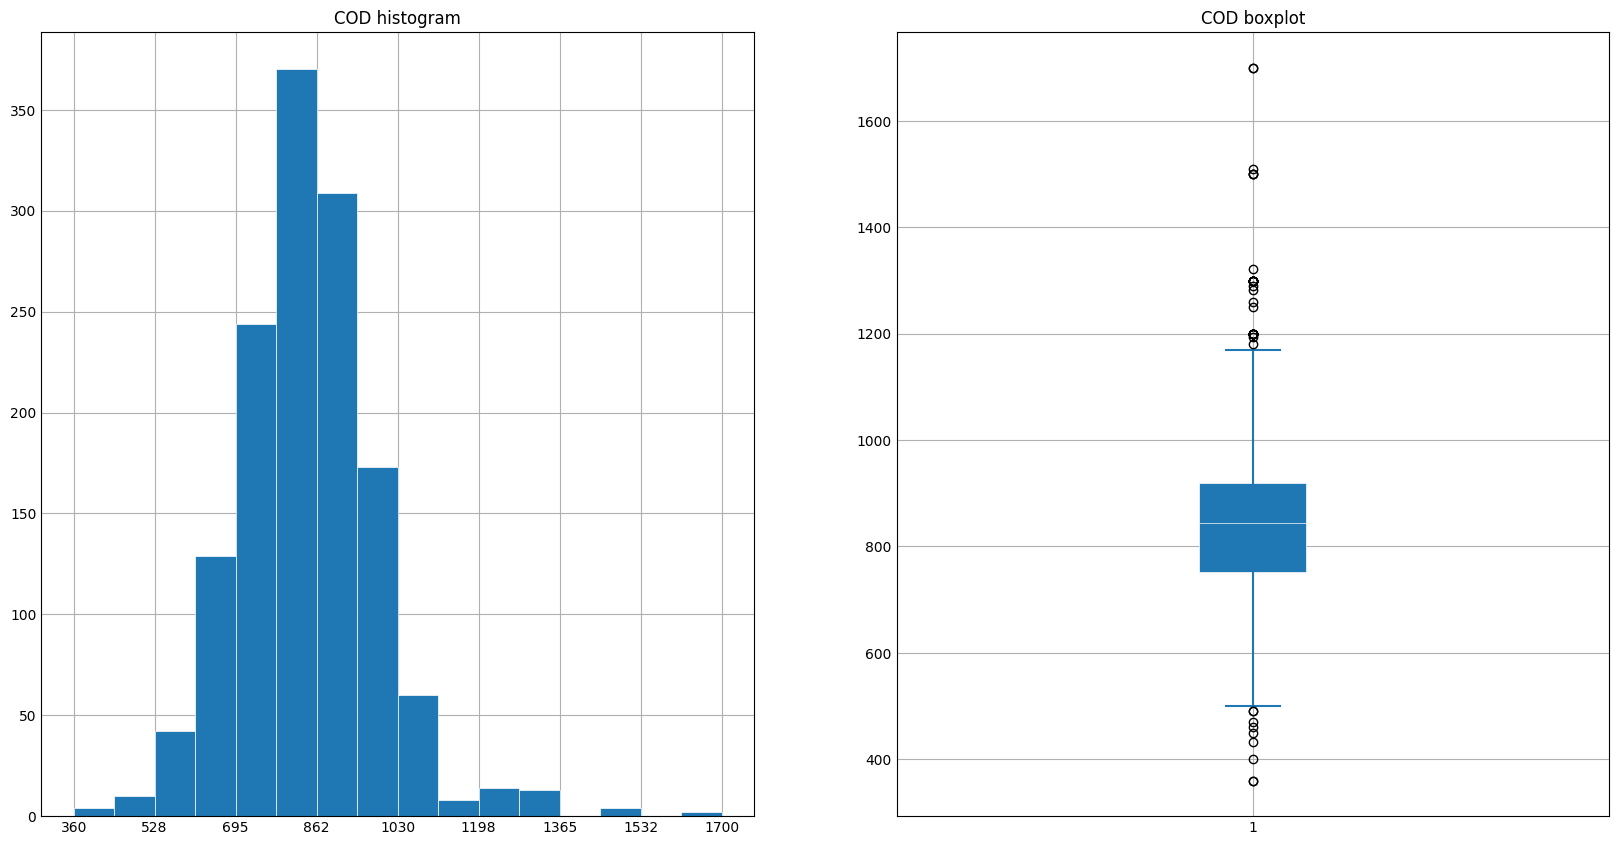

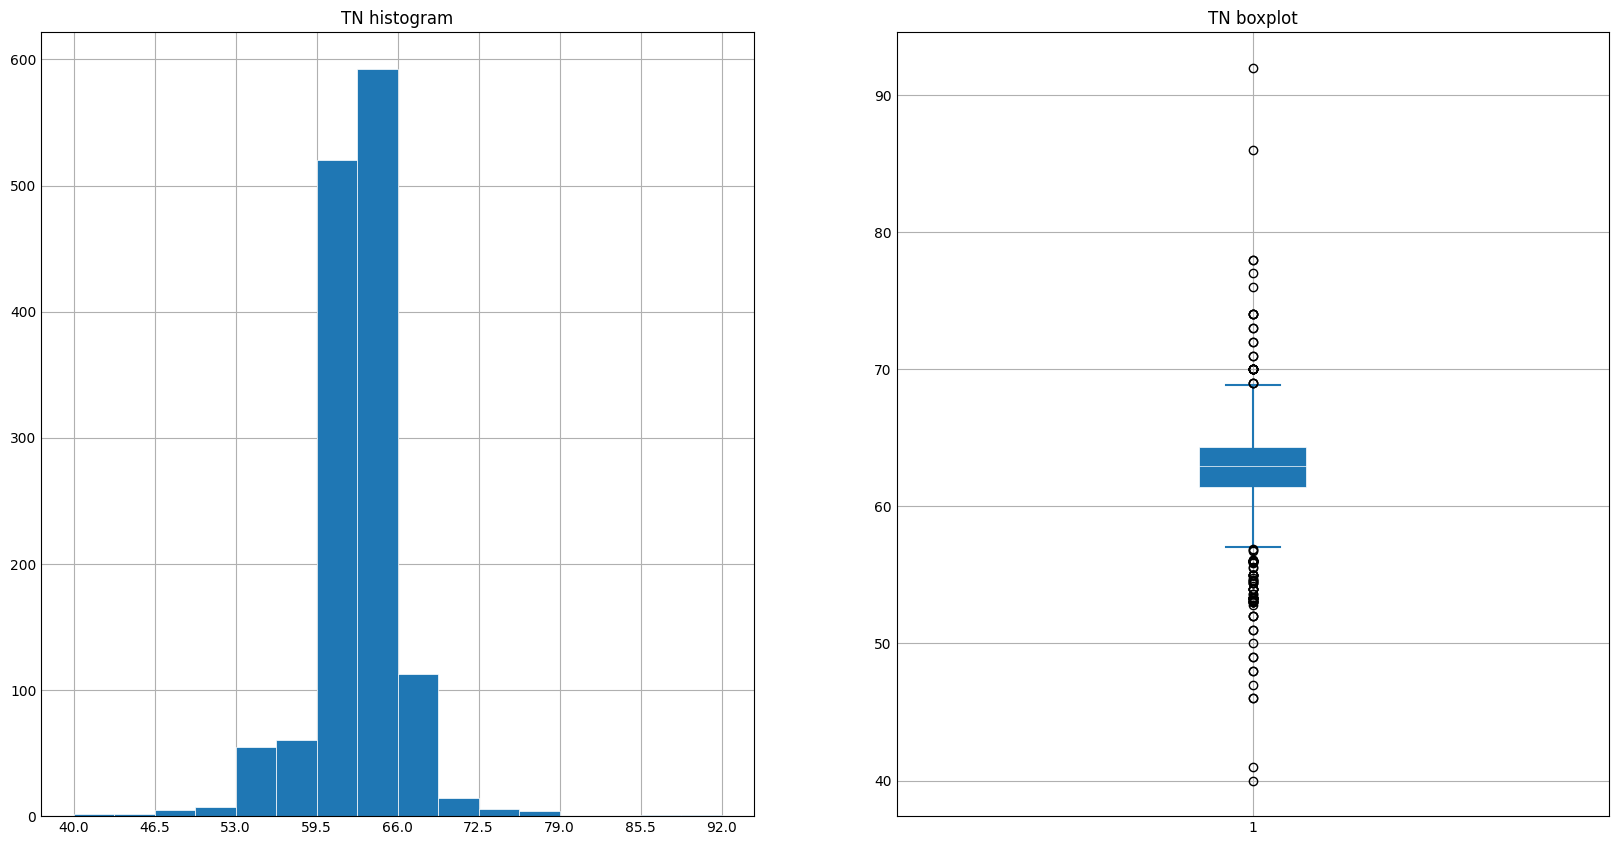

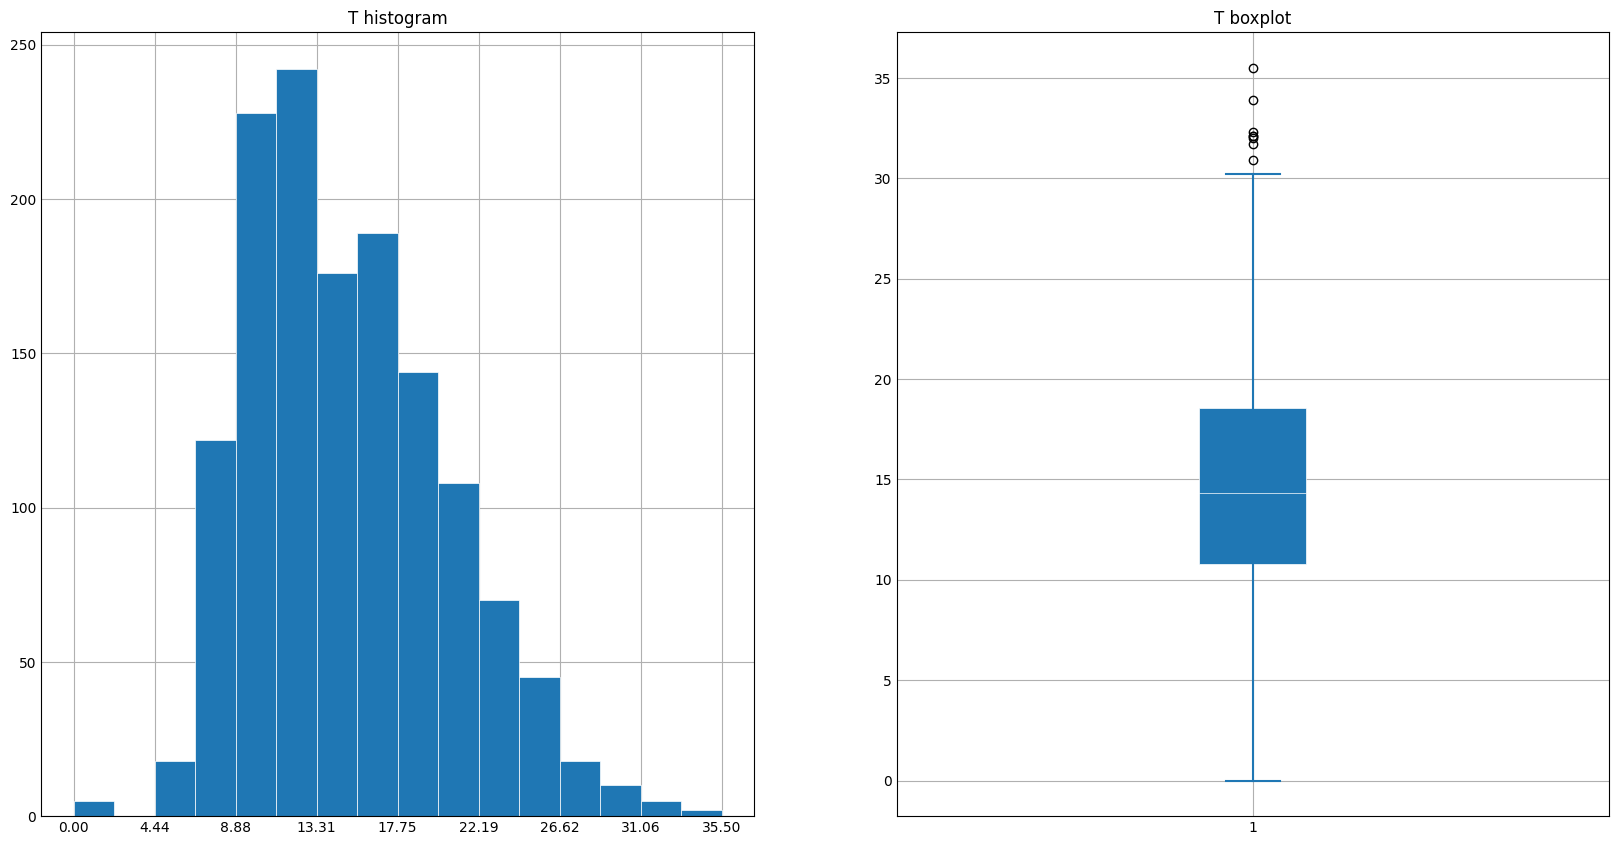

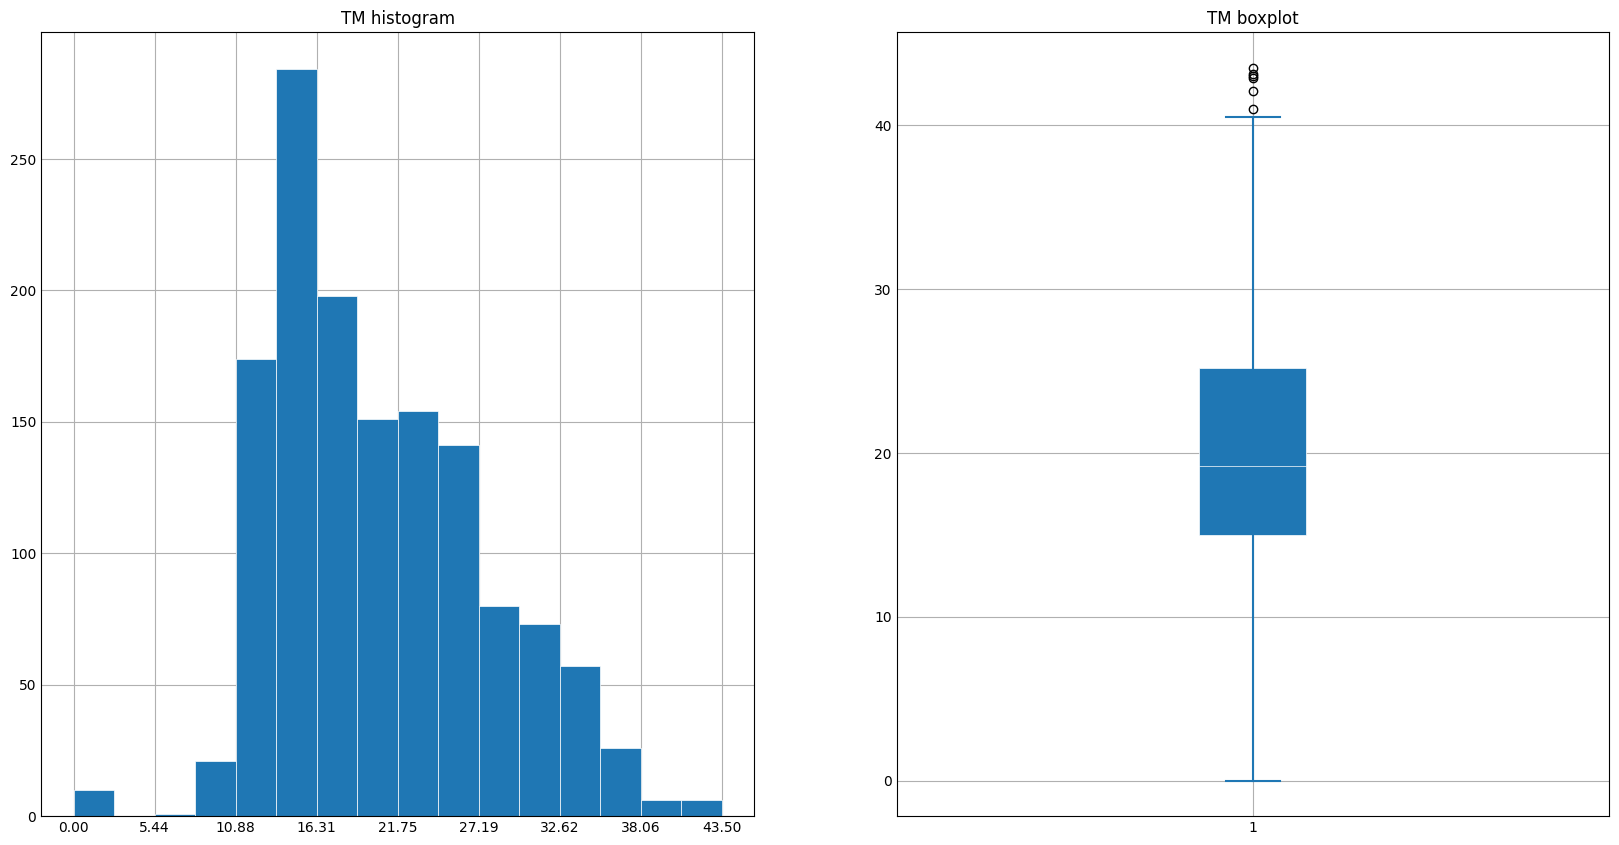

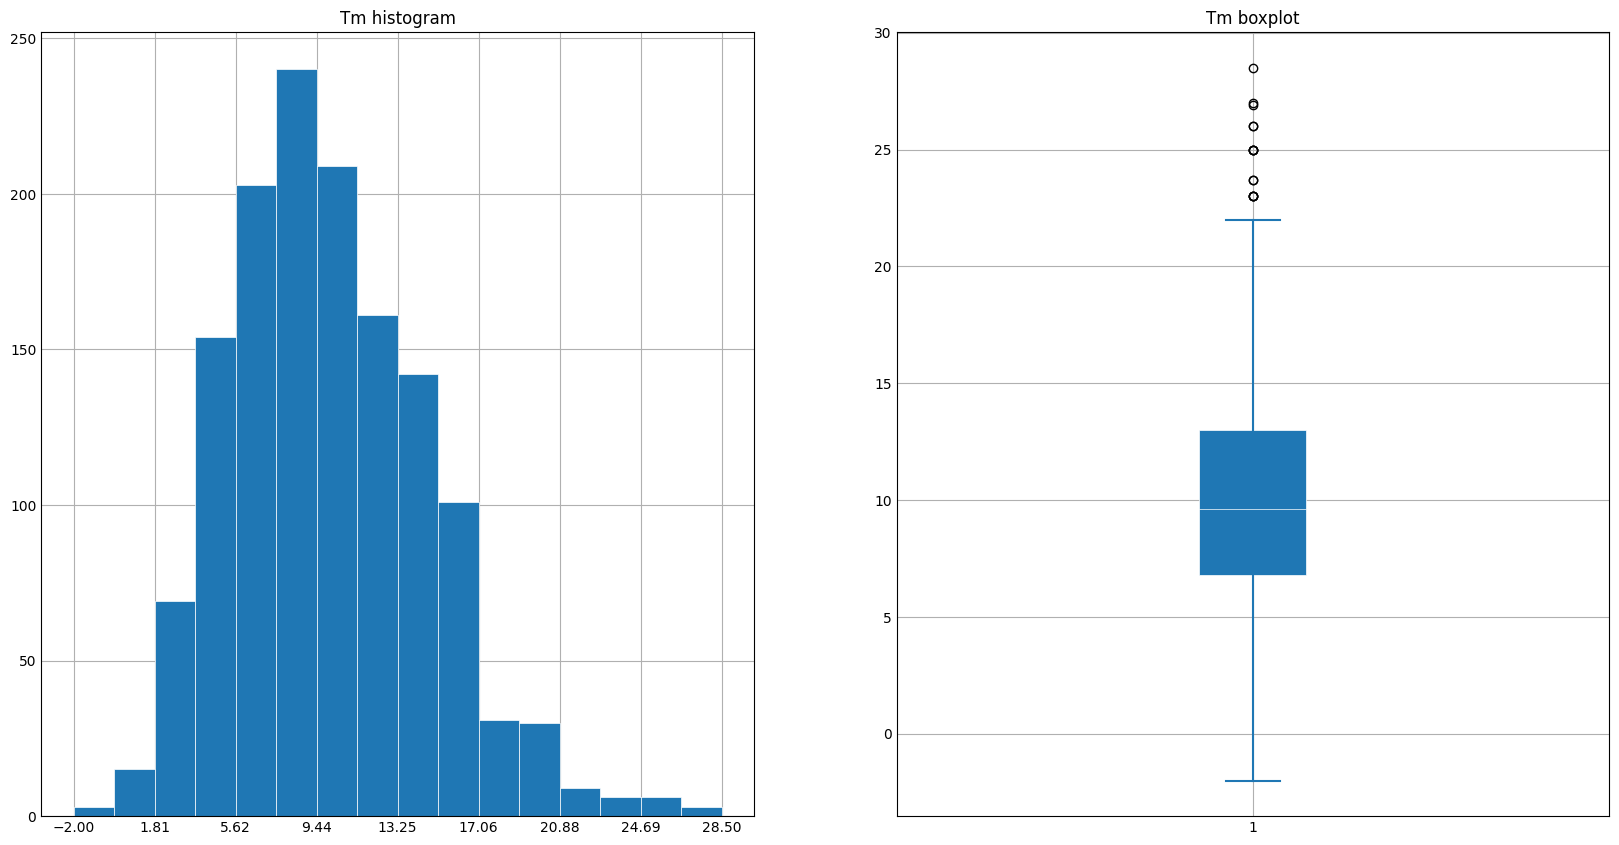

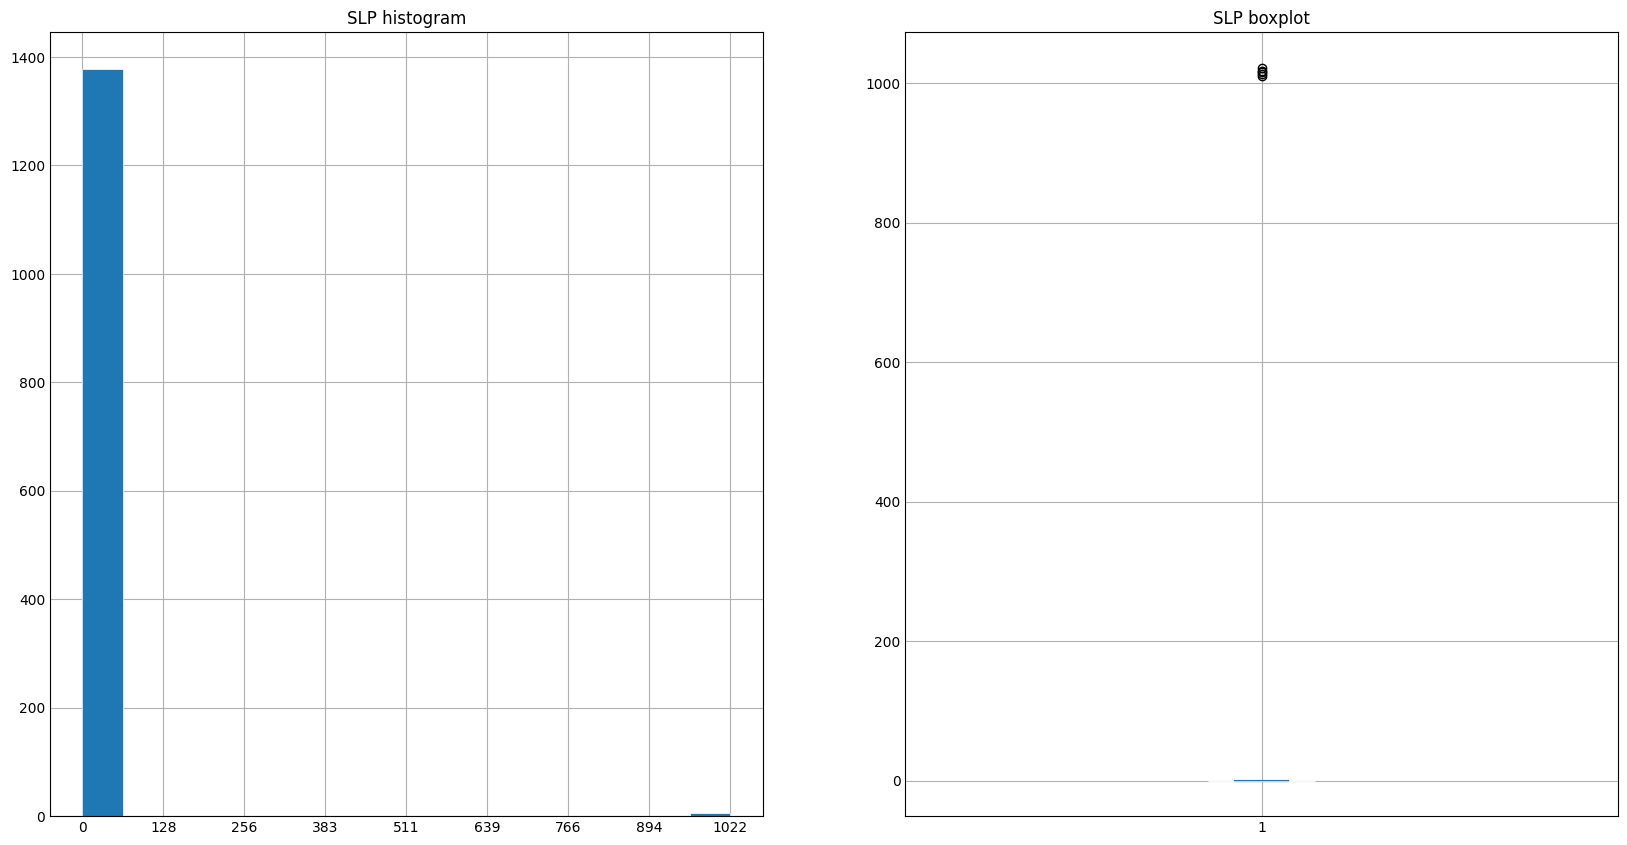

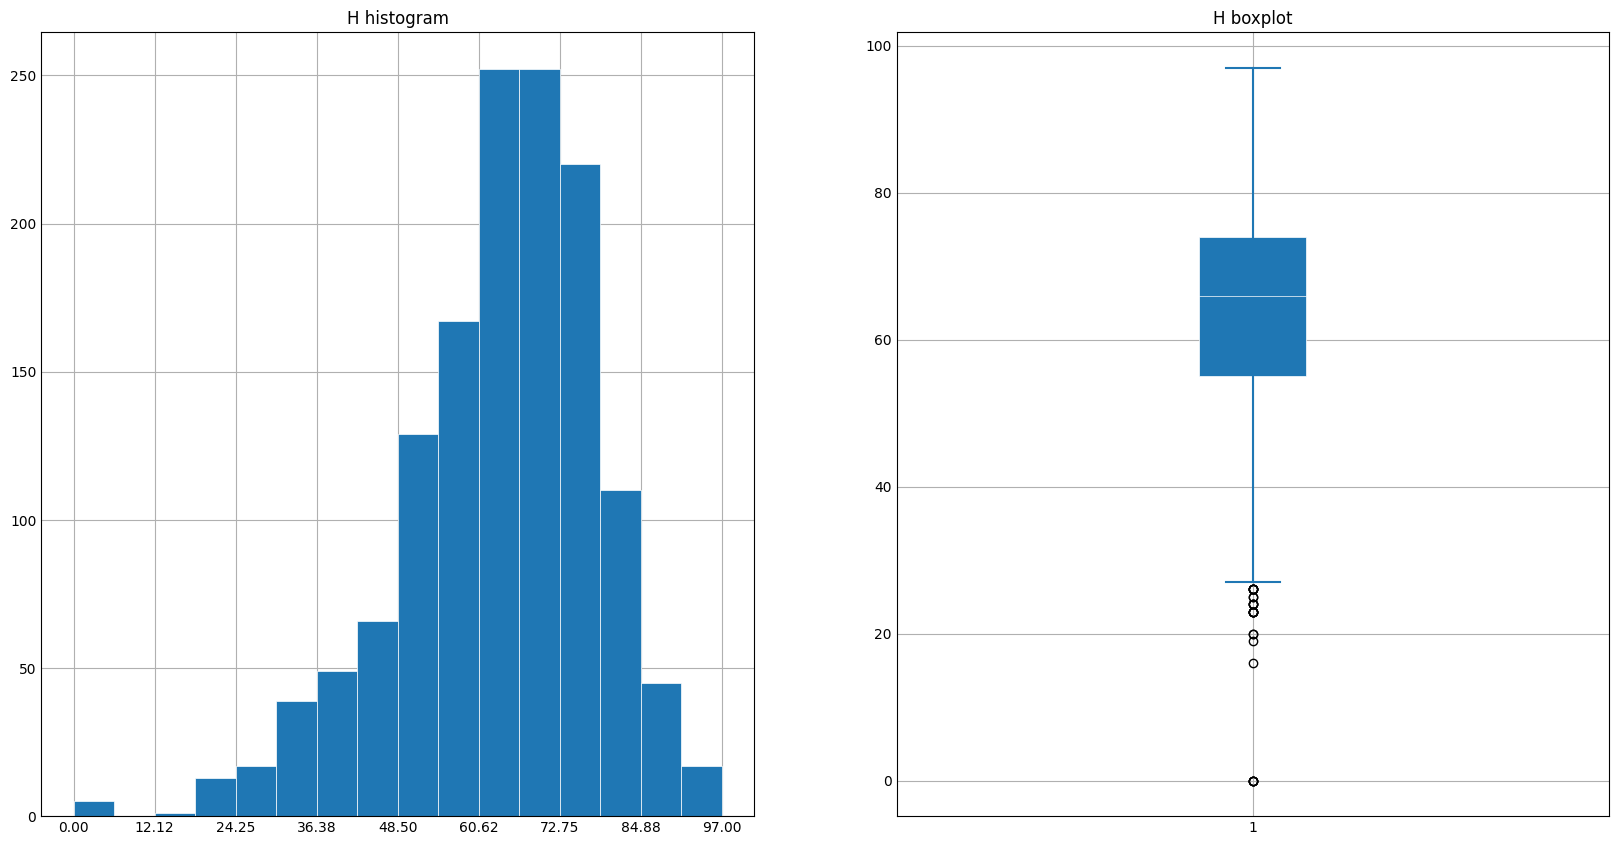

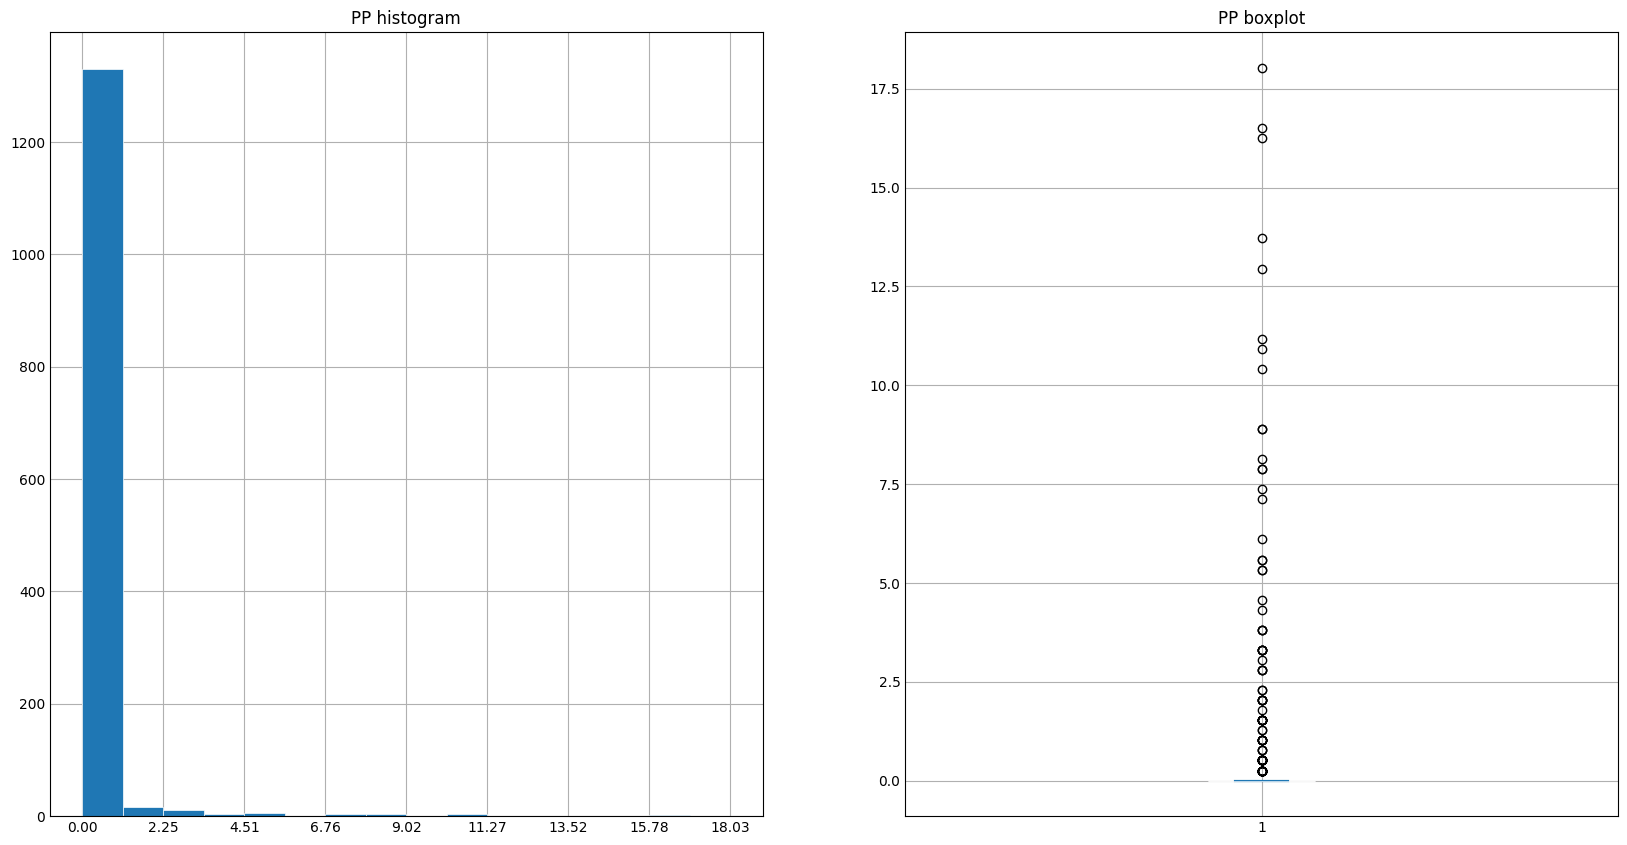

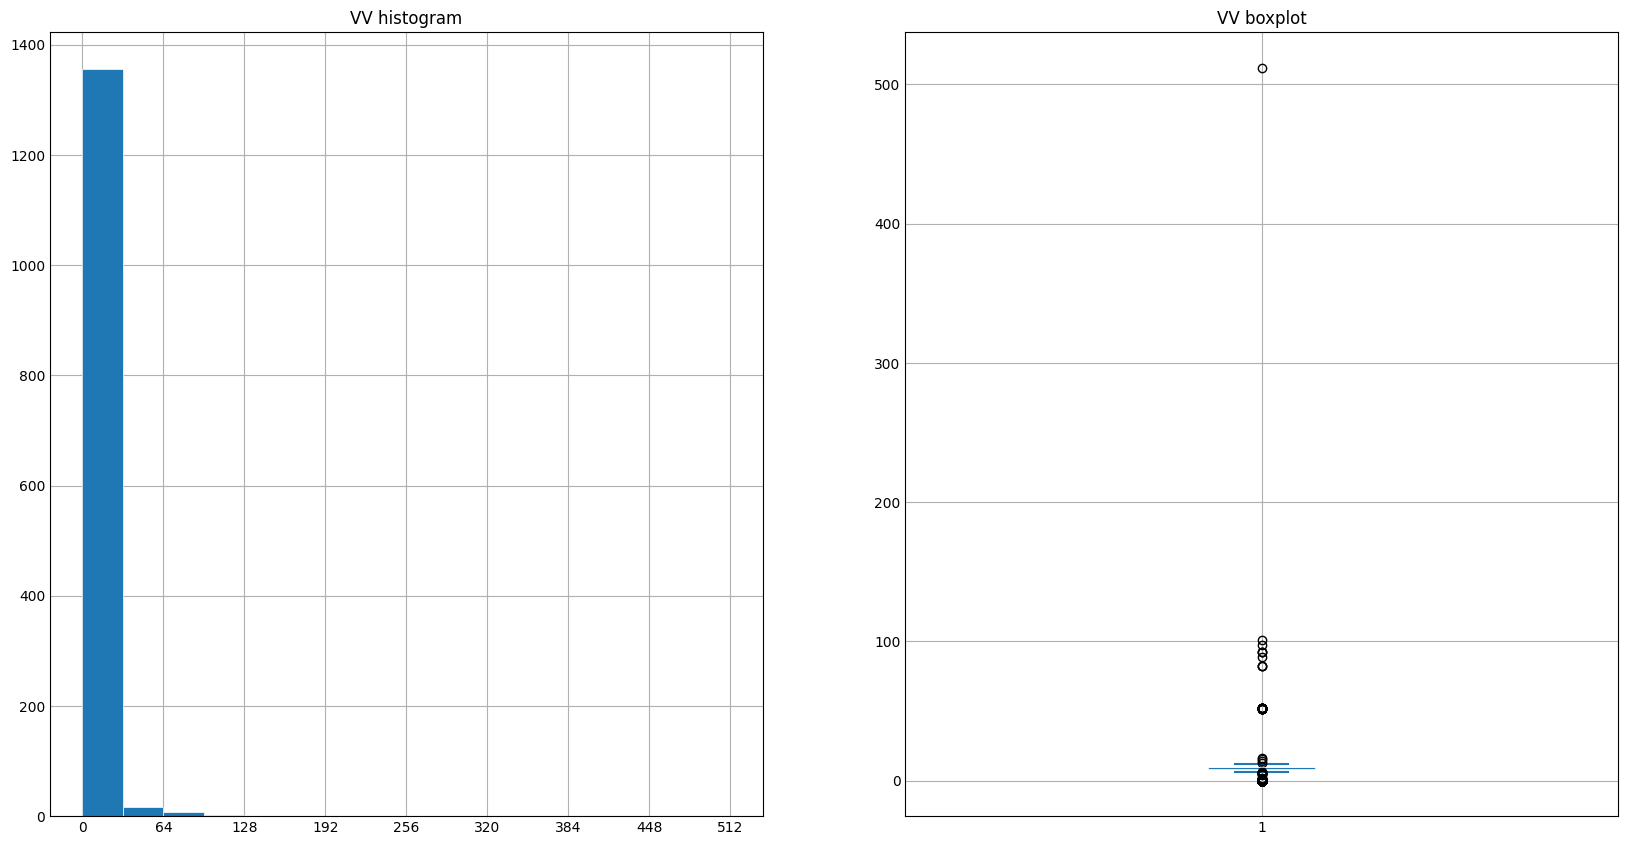

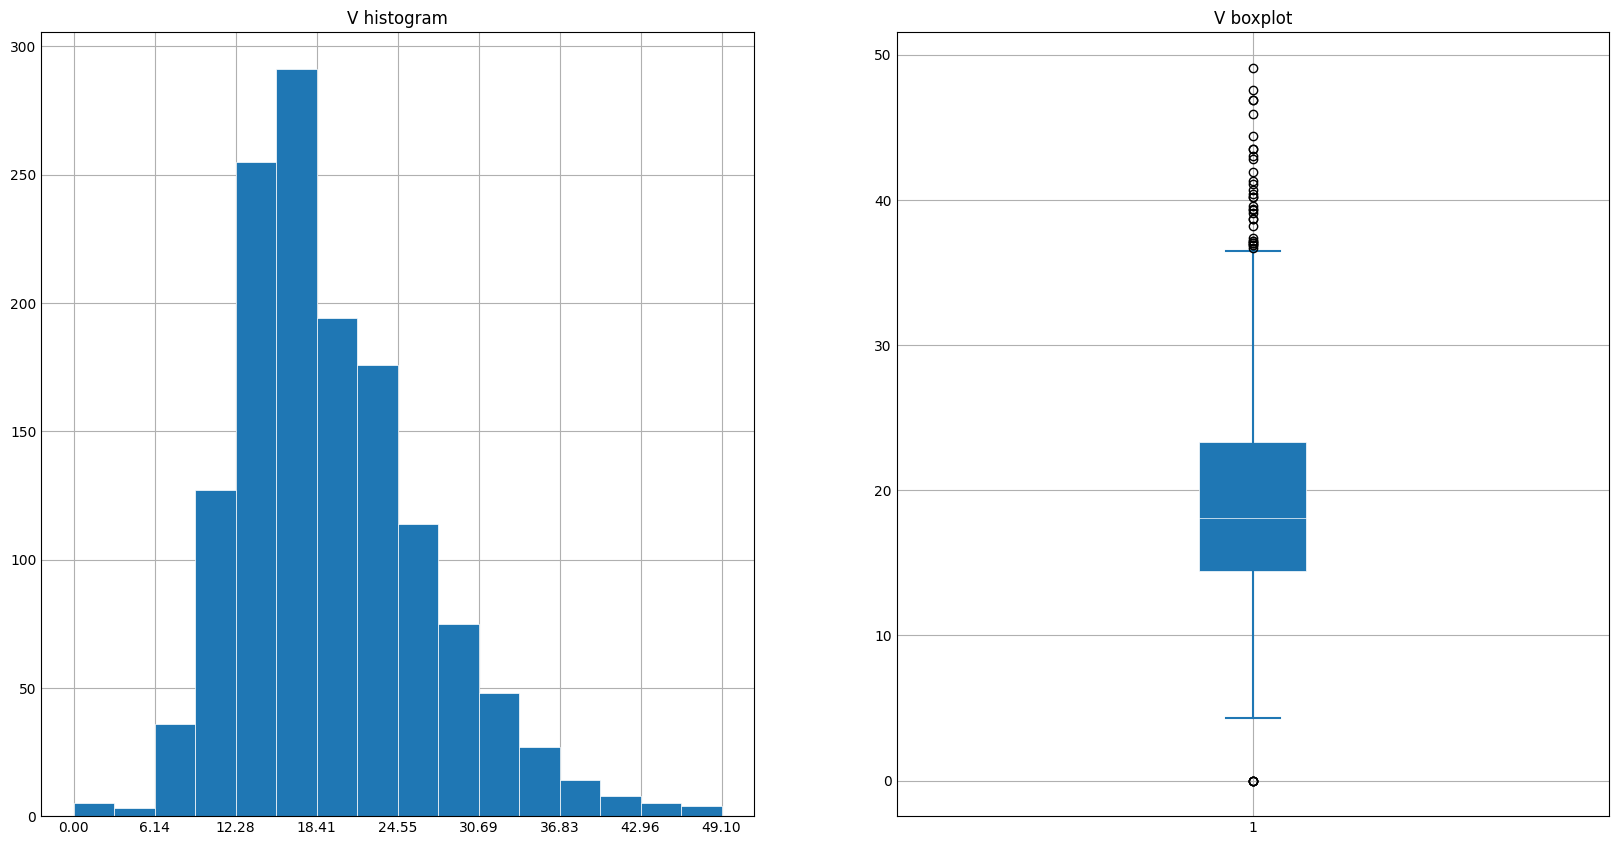

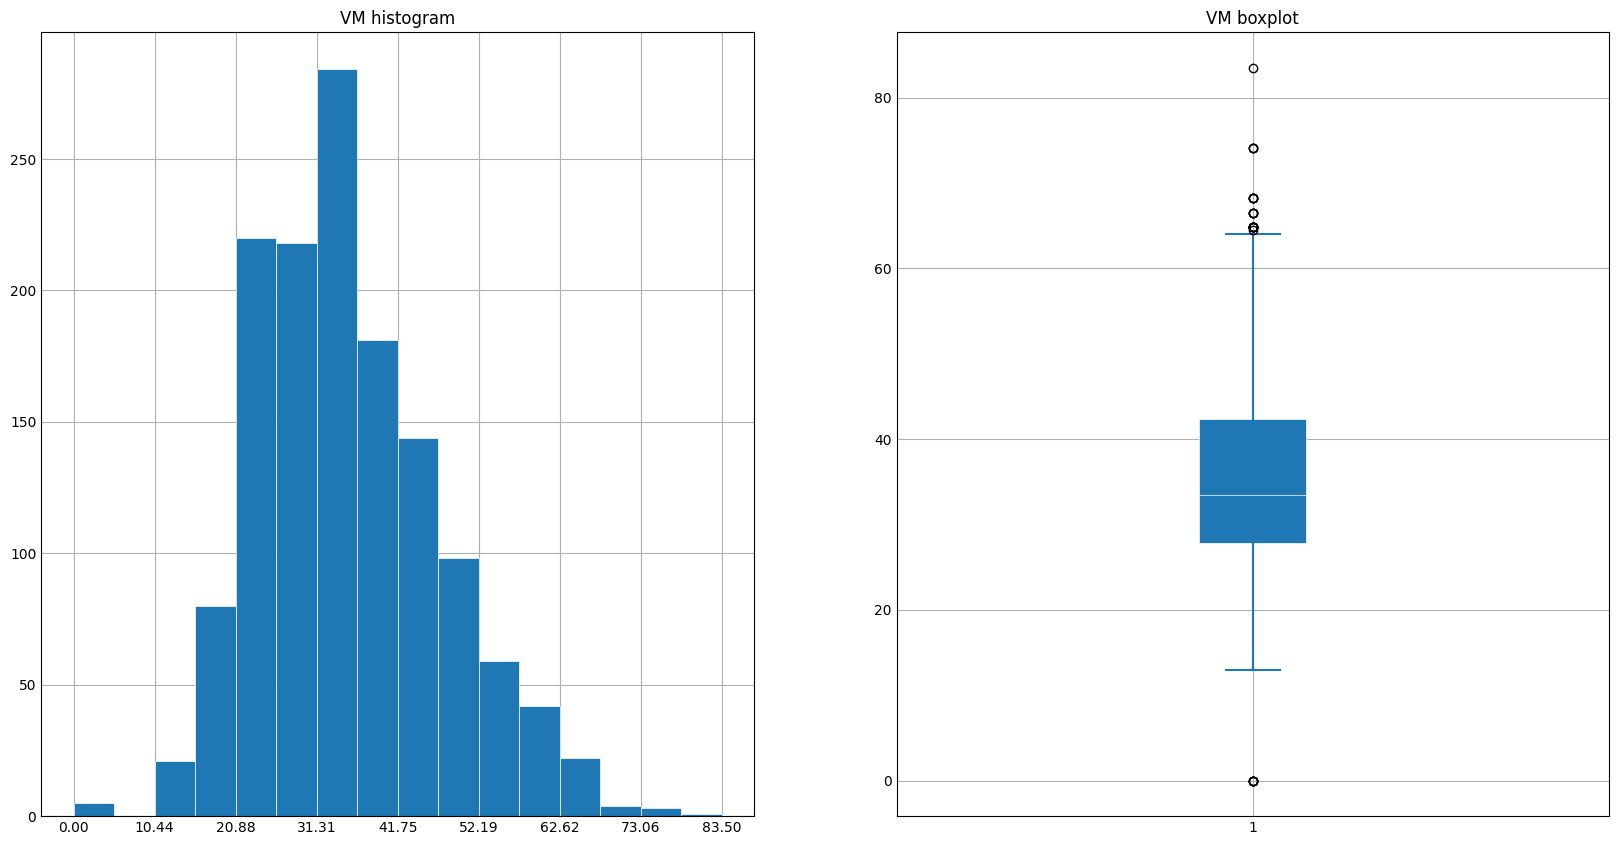

In [10]:
uncond_analysis = pd.DataFrame(columns=['name', 'mean', 'standard_deviation', 'skewness'])

for i, predictor in enumerate(df.columns):
    uncond_analysis.loc[i] = [predictor, df[predictor].mean(), df[predictor].std(), df[predictor].skew()]

    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
uncond_analysis.index = uncond_analysis.index + 1
uncond_analysis

In [11]:
# Unconditional bi-variate analysis of the predictors

#pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(16,16), grid=False, diagonal={'kde'})

pairgrid = sns.pairplot(
    df,
    height=1,
    aspect=1,
    plot_kws=dict(
        s=64,                 # marker size
        alpha=0.5,           # transparency
        marker='.',          # marker type ('o', '^', '.', 'x', etc.)
        edgecolor="blue",   # thin black edge (set to 'none' to disable)
        linewidth=0.1,
)

for ax in pairgrid.axes.flatten():
    if ax is not None:
        ax.grid(False)
        ax.set_facecolor("white")

        # Remove tick marks and labels
        ax.set_xticks([])
        ax.set_yticks([])

pairgrid.fig.tight_layout(pad=0.2)
plt.show()

SyntaxError: '(' was never closed (ipython-input-2895706358.py, line 5)

,name,mean,standard_deviation,skewness
1,avg_outflow,4.262056,1.296790,0.088625
2,avg_inflow,4.735592,1.528899,2.218092
3,total_grid,281902.521127,54706.433744,-0.519219
4,Am,31.746479,9.088011,0.237718
5,BOD,266.232394,33.445887,-1.512467
6,COD,600.140845,73.769583,-0.867481
7,TN,57.123014,4.389186,-1.096904
8,T,13.623944,6.152316,1.018725
9,TM,18.707042,8.227138,1.014615
10,Tm,9.430986,5.063471,0.788335


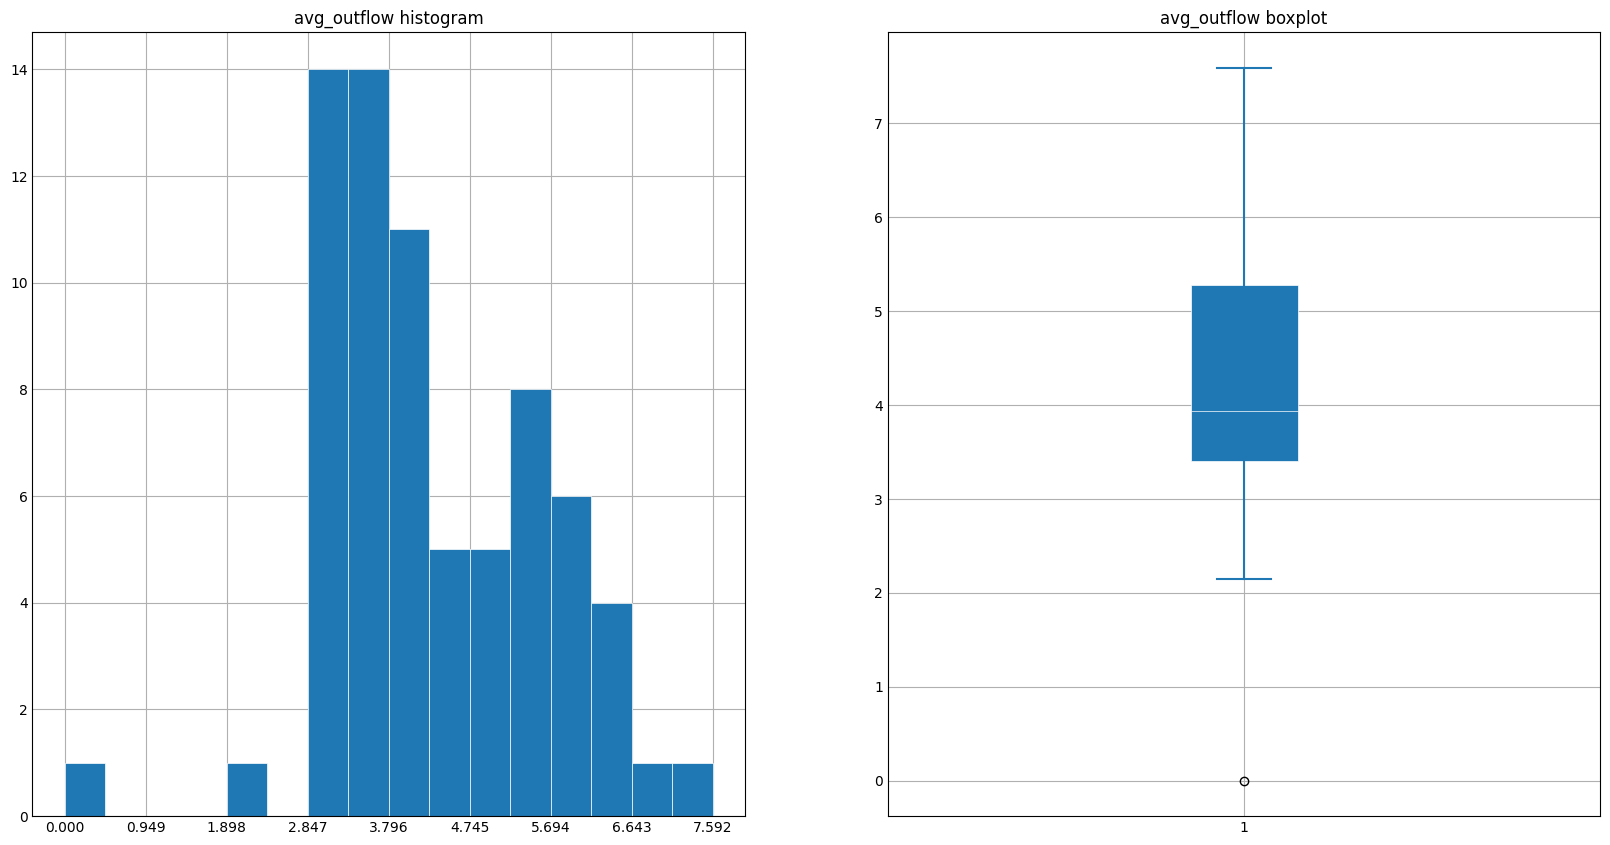

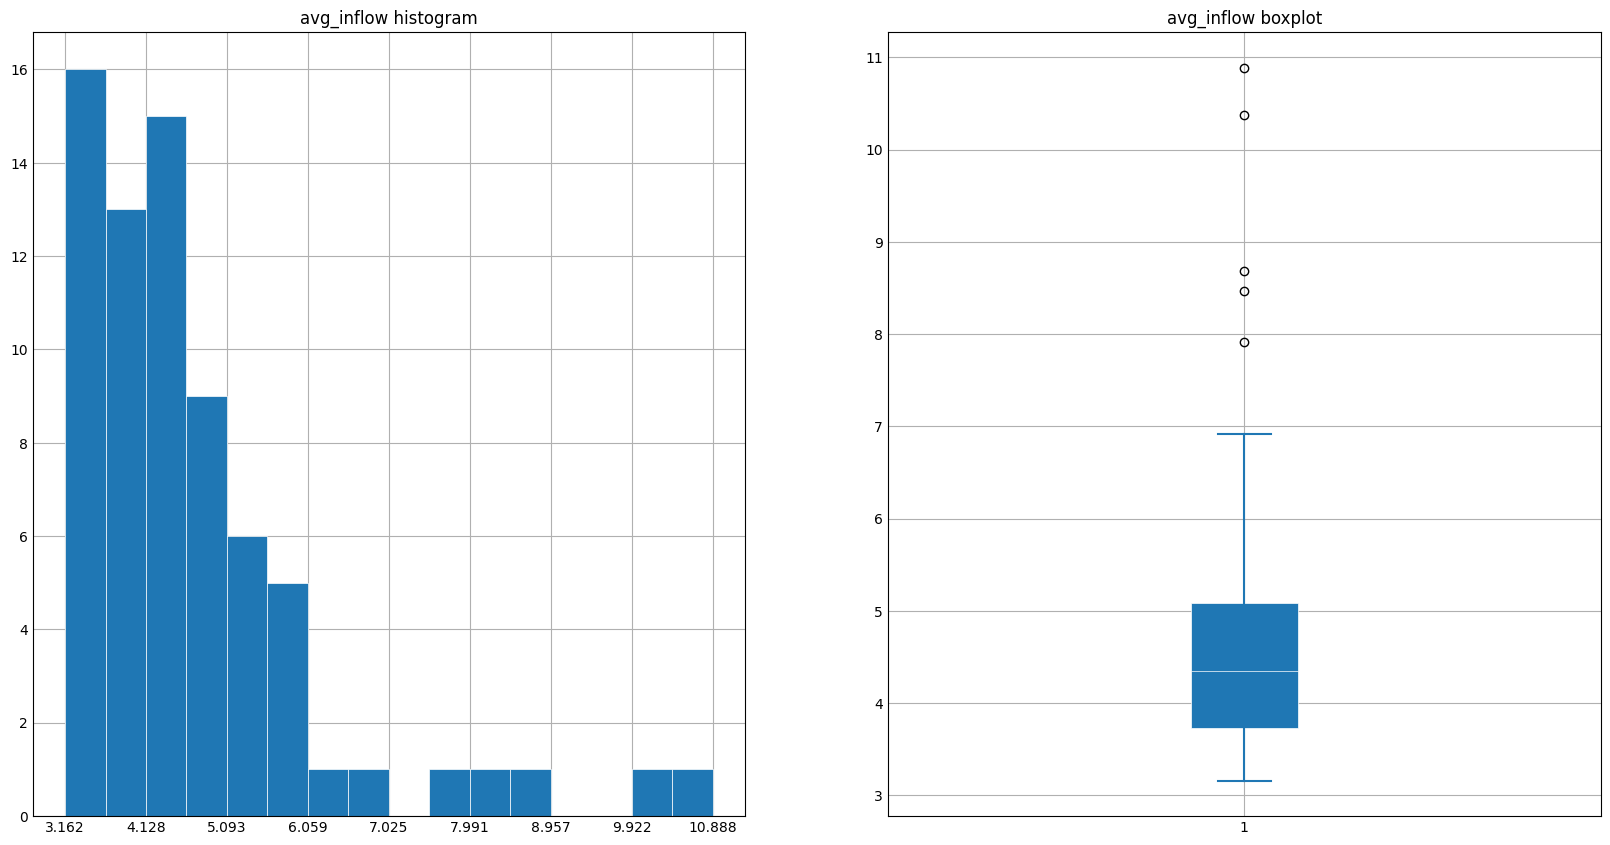

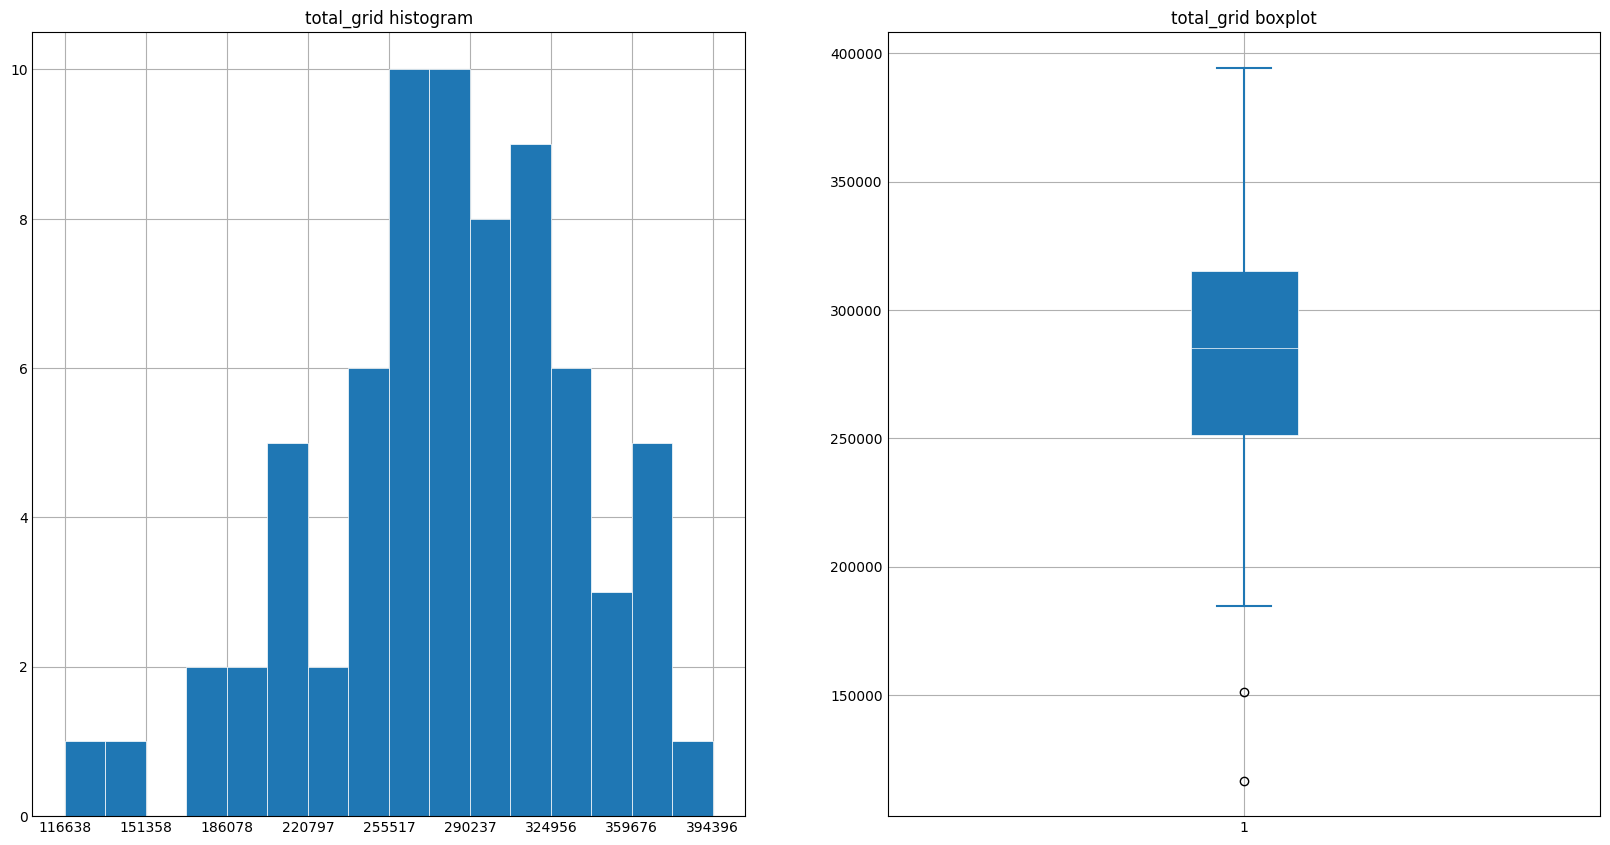

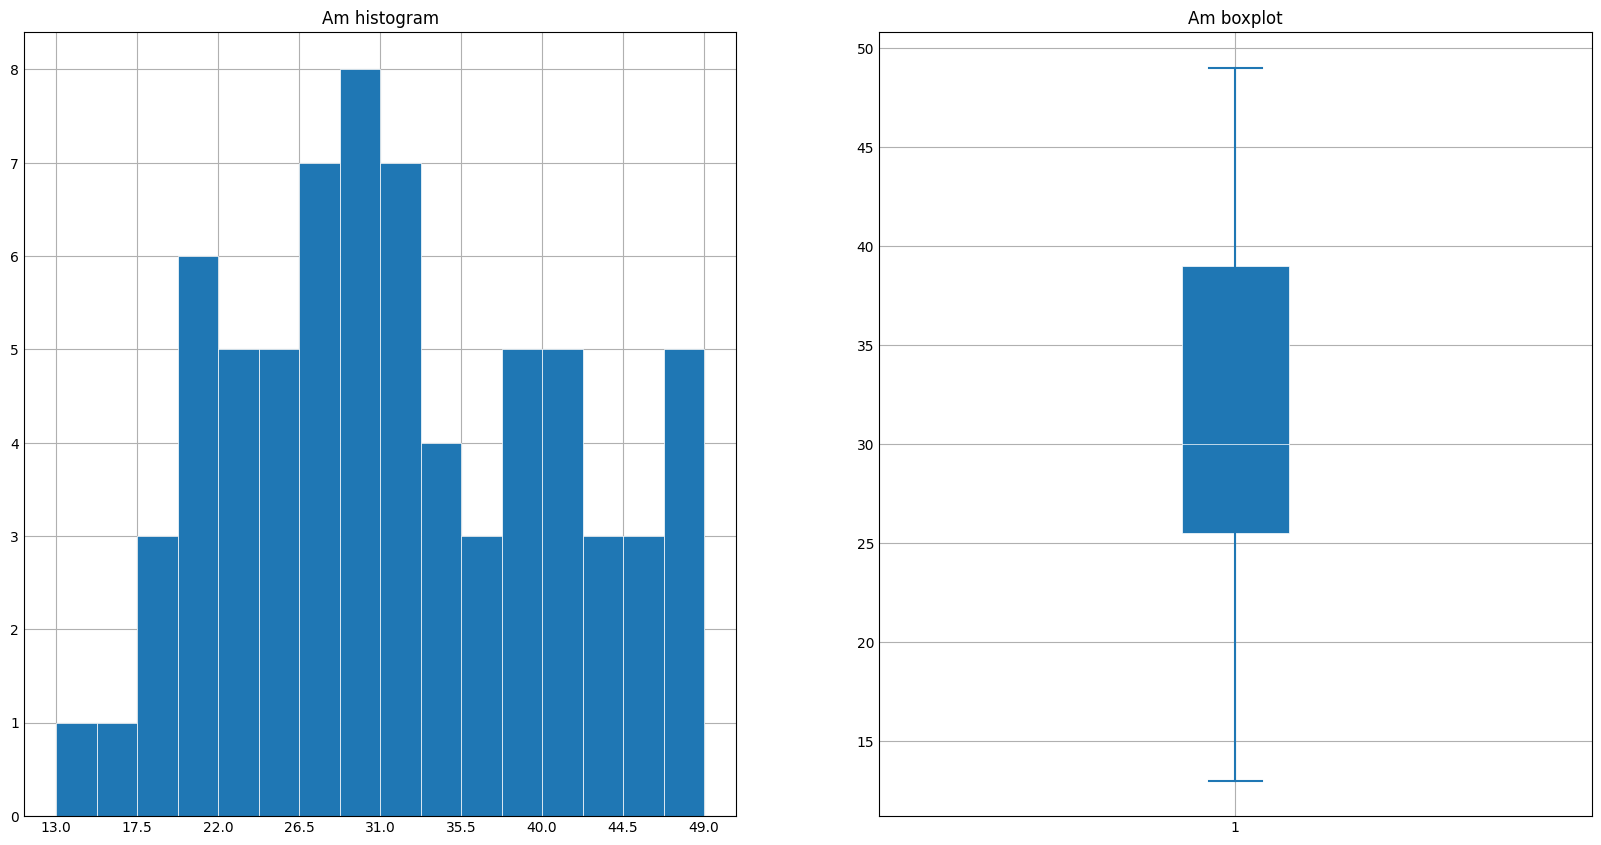

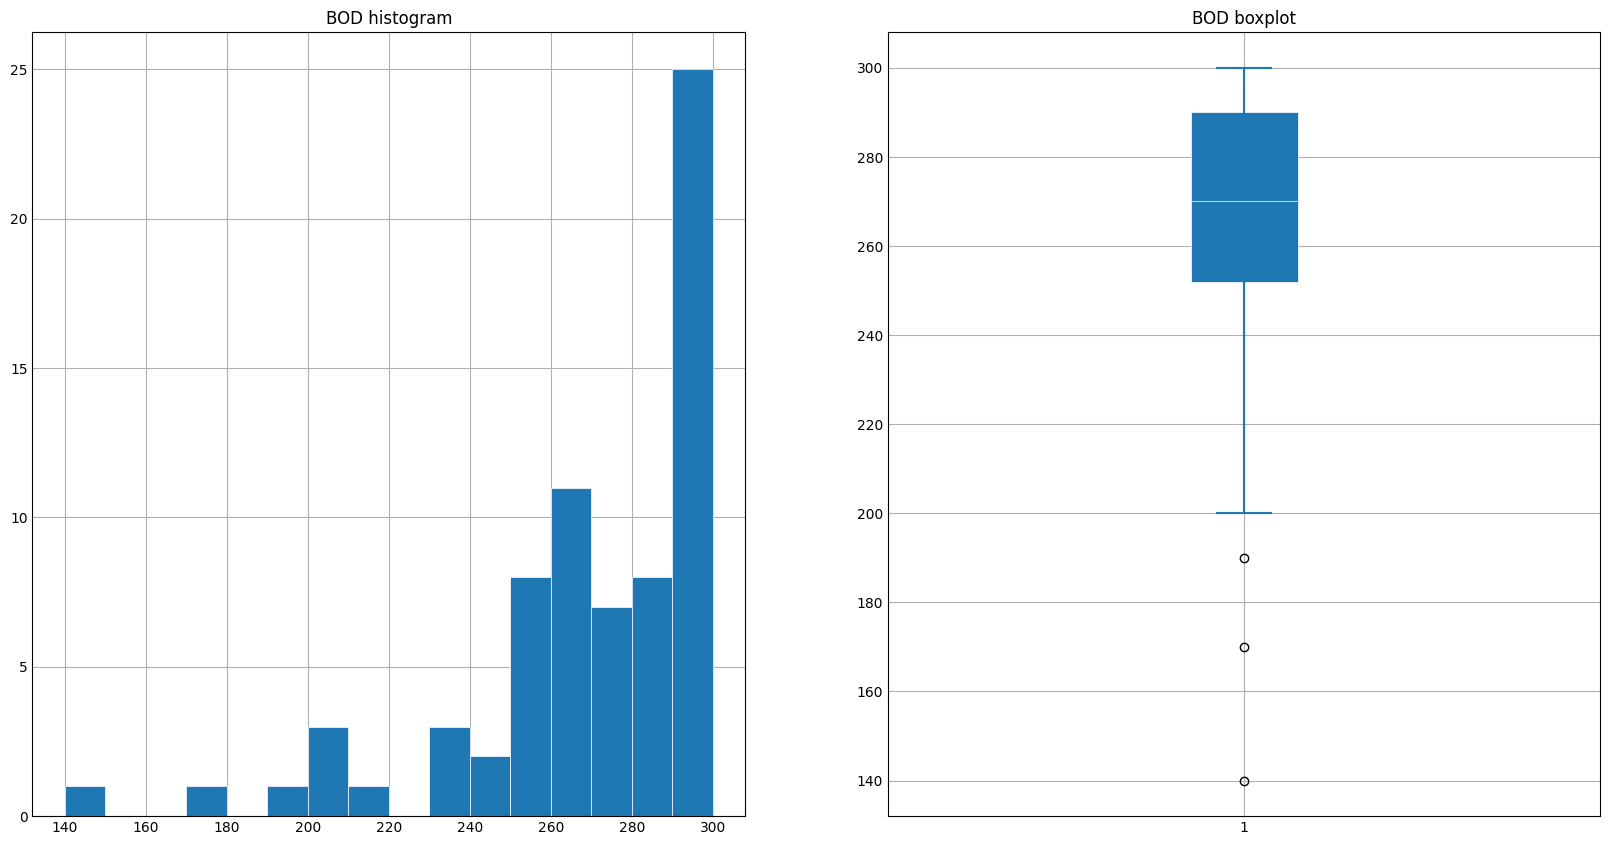

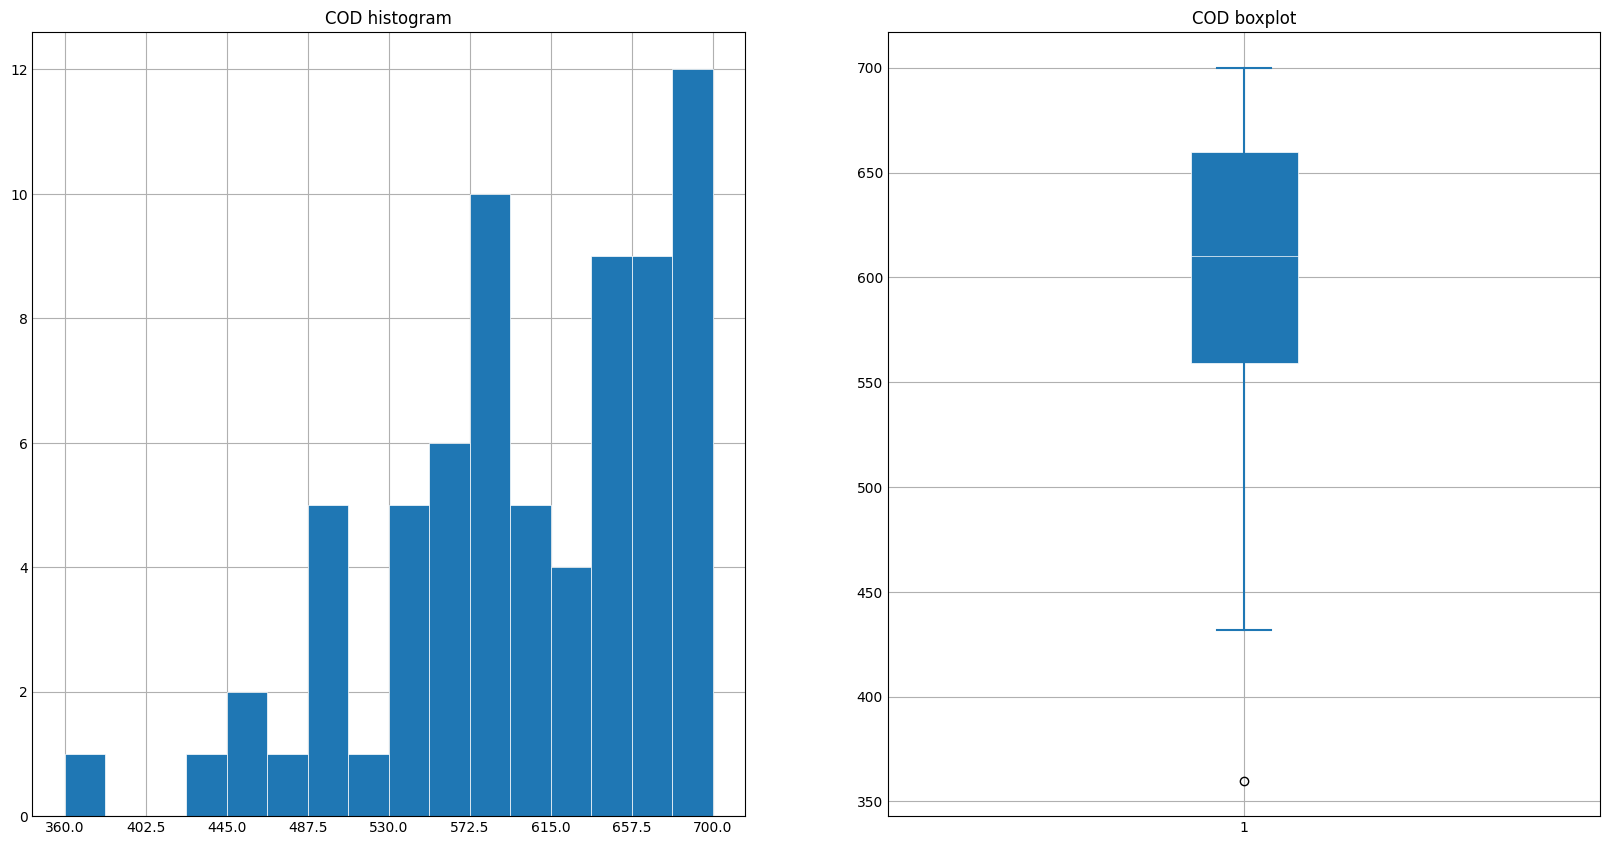

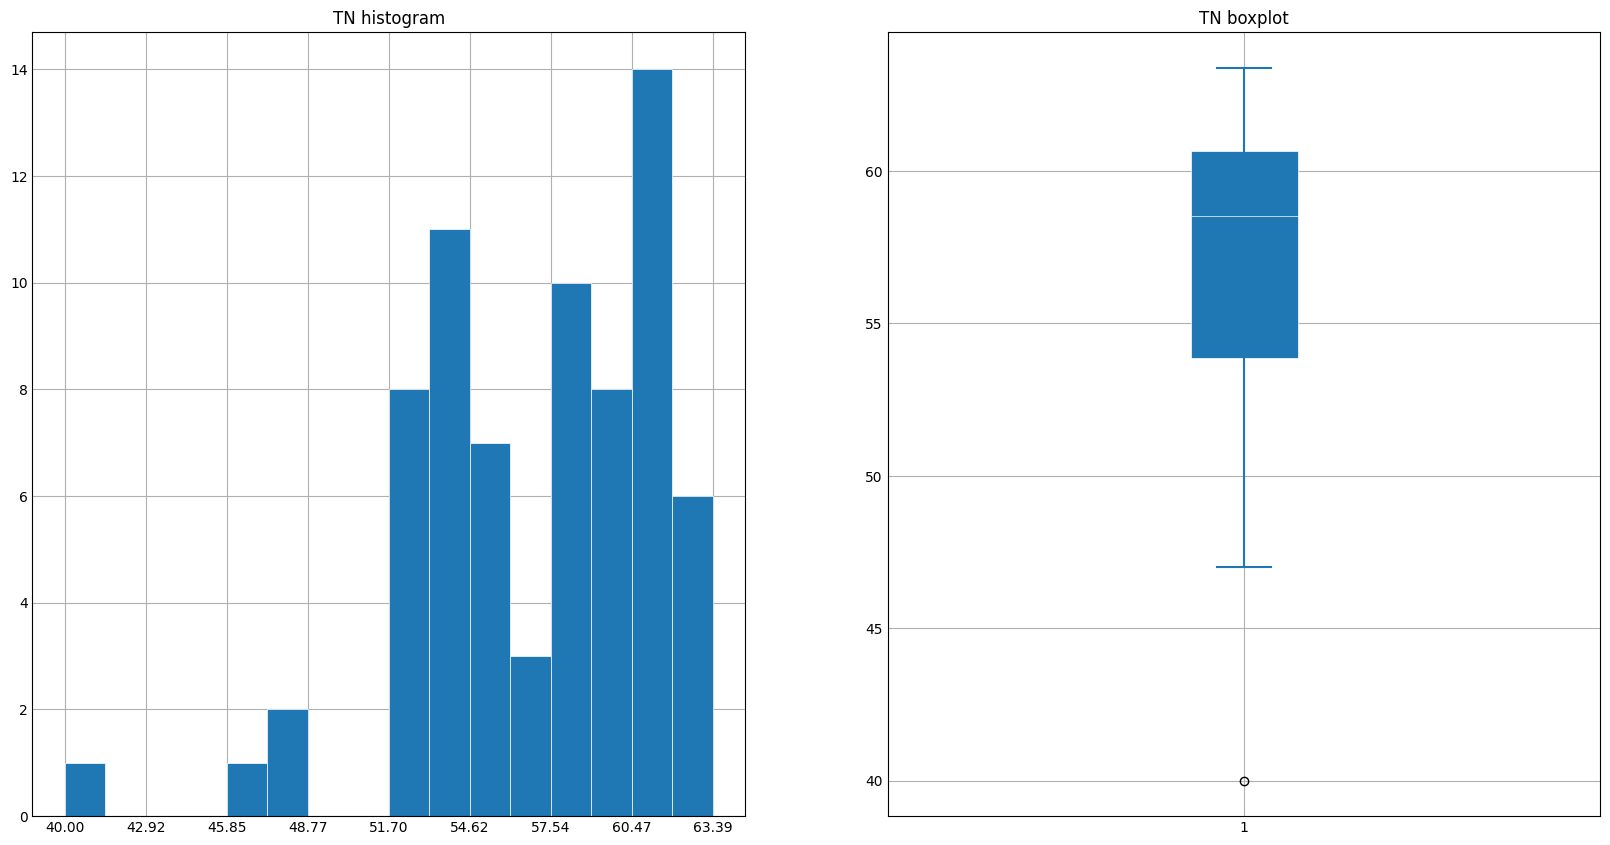

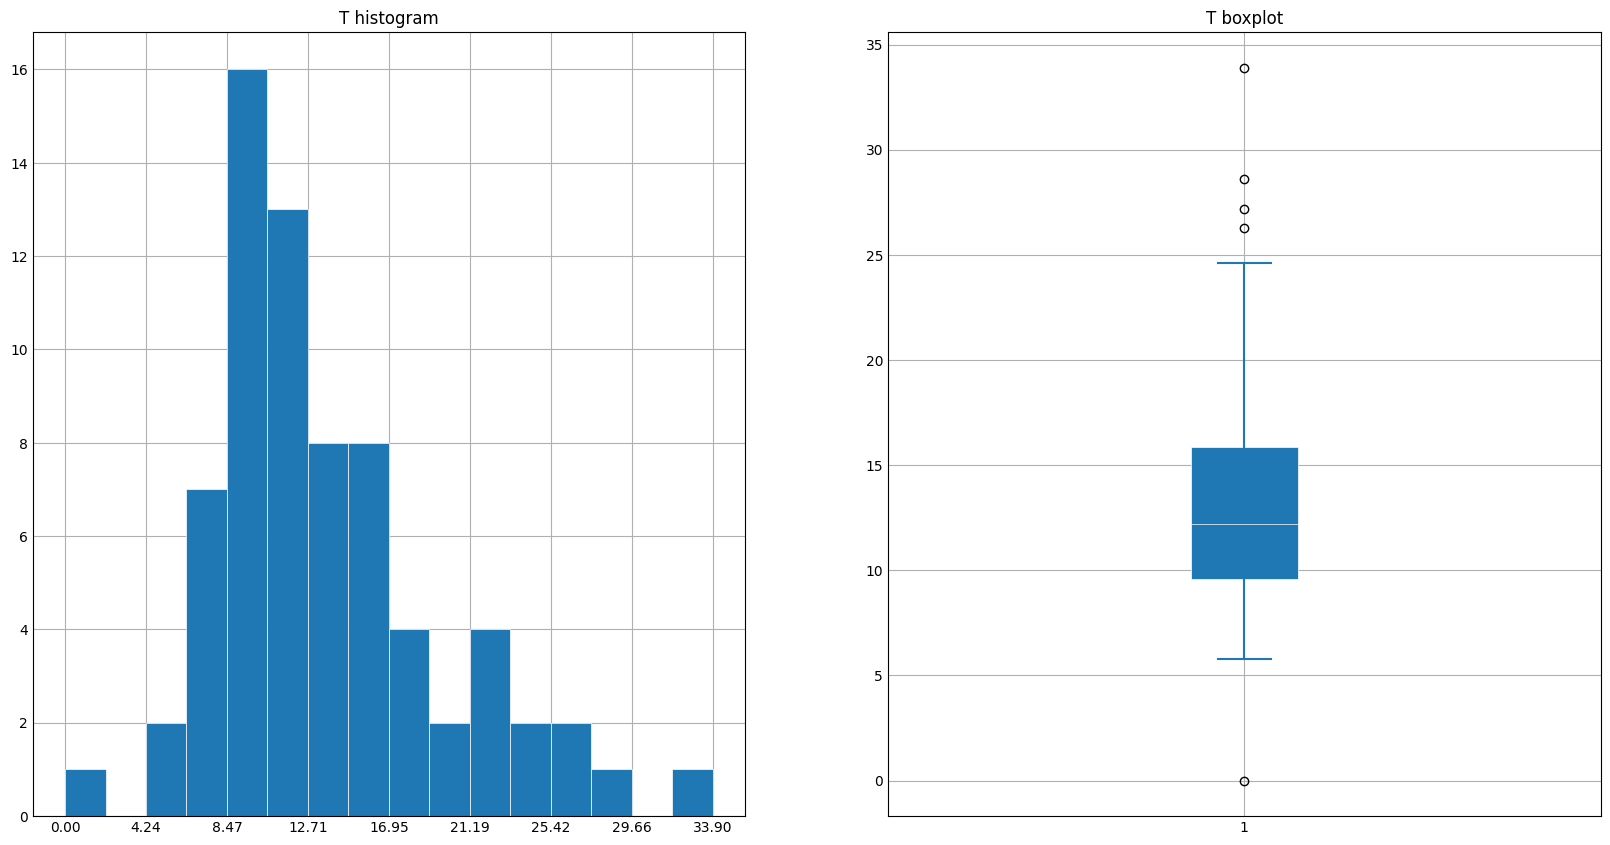

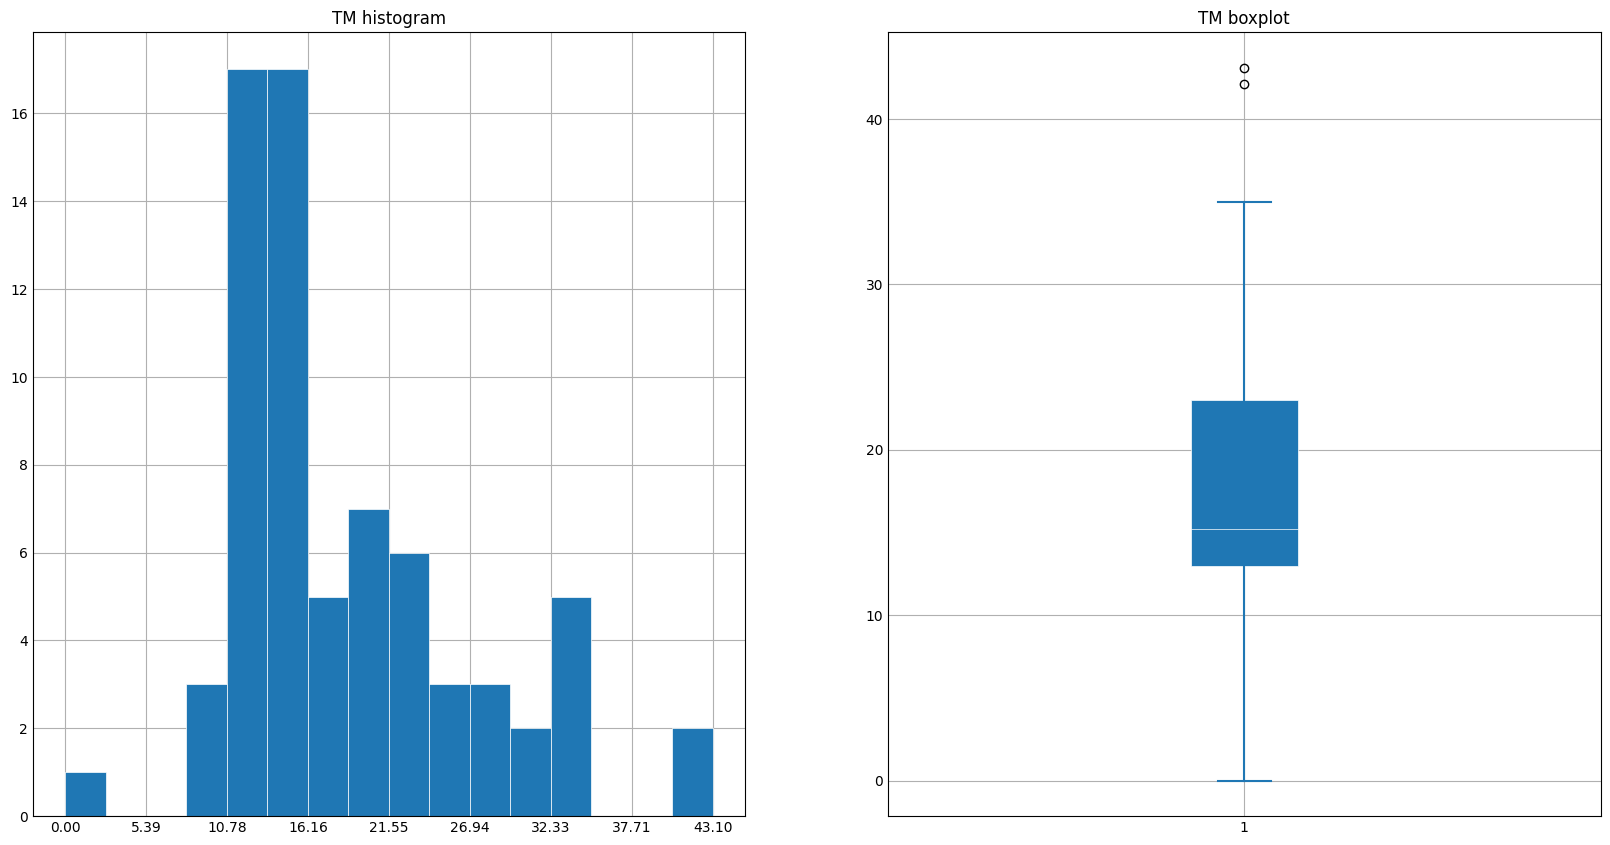

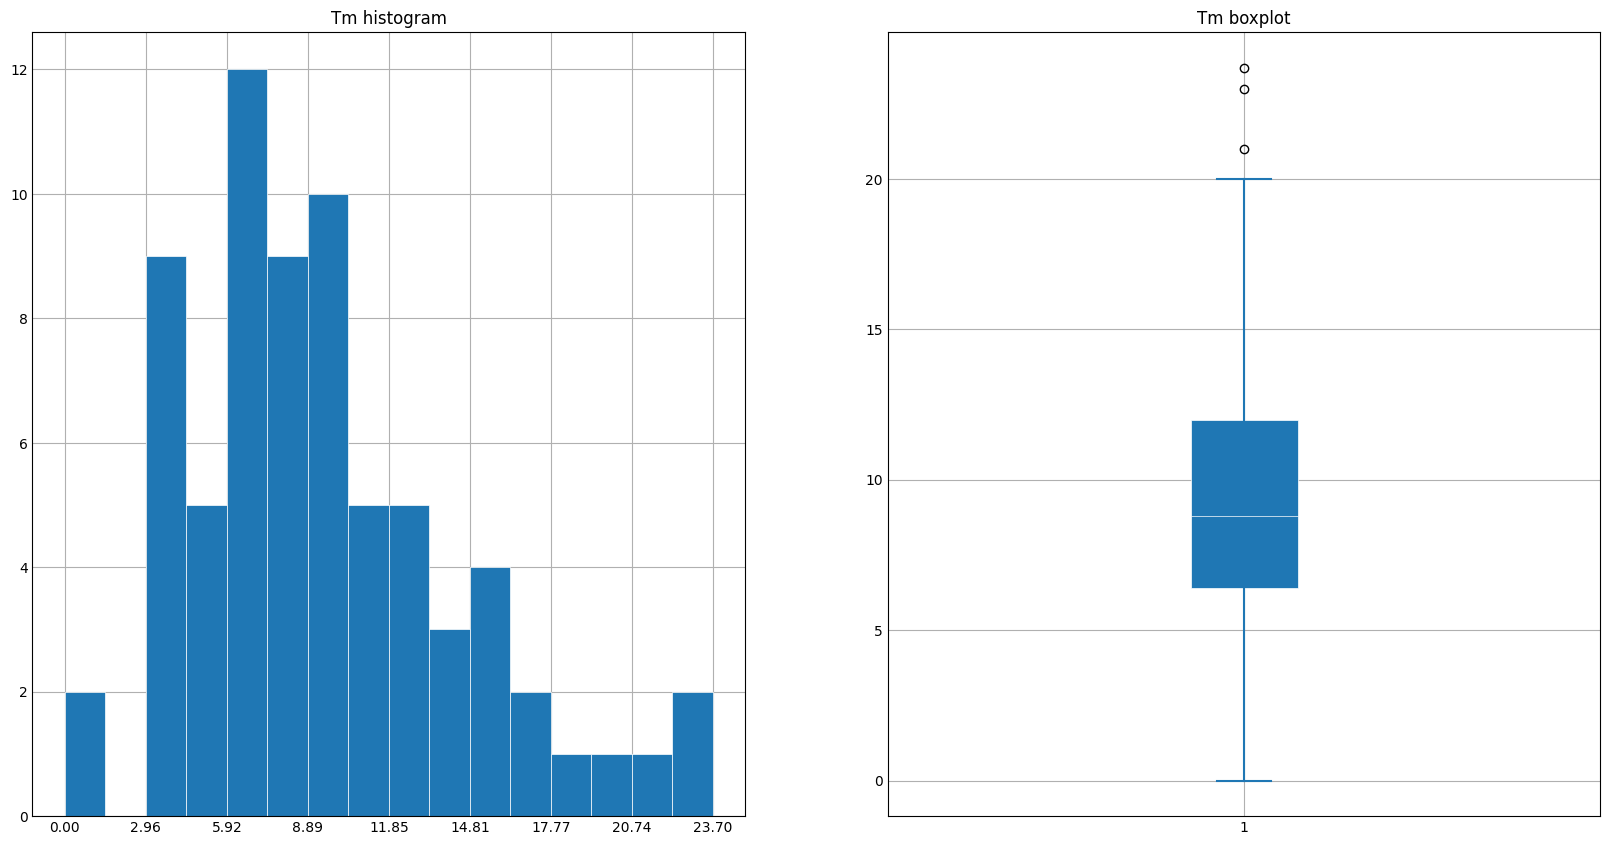

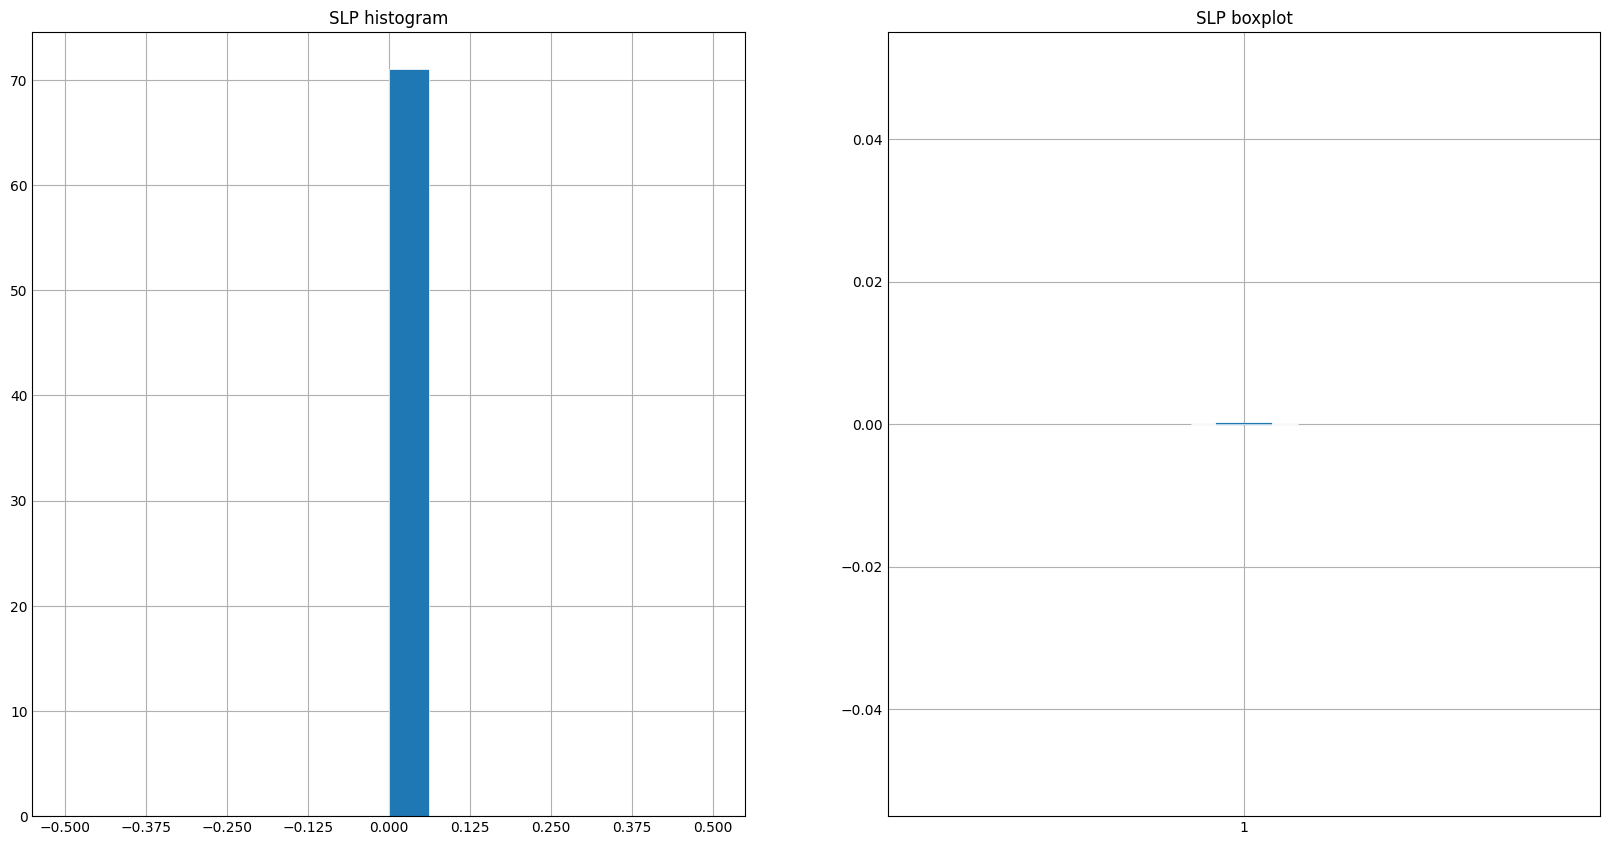

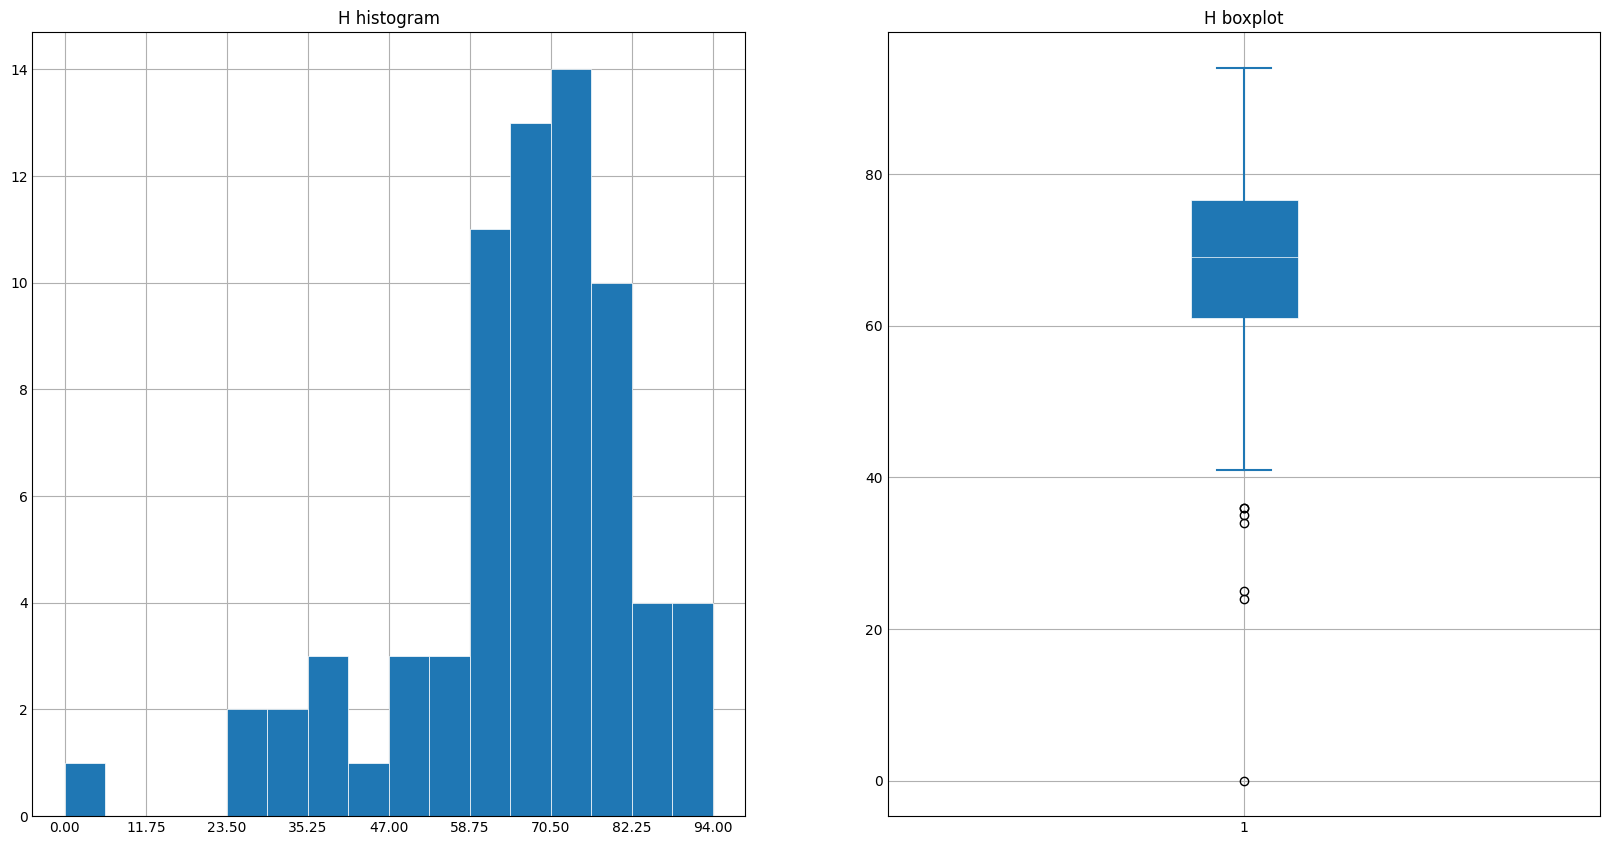

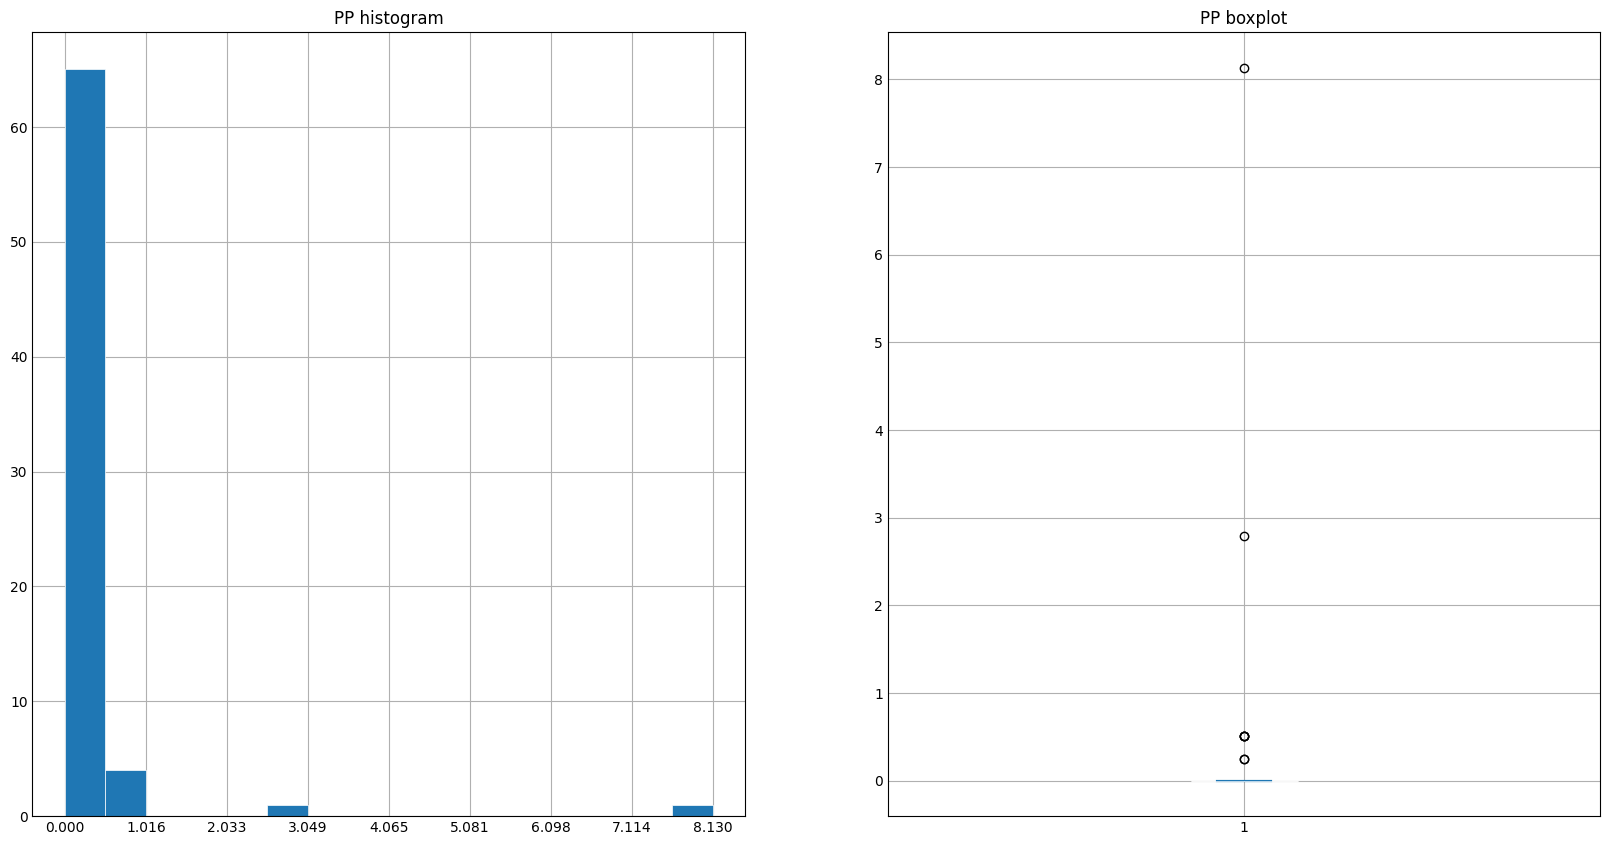

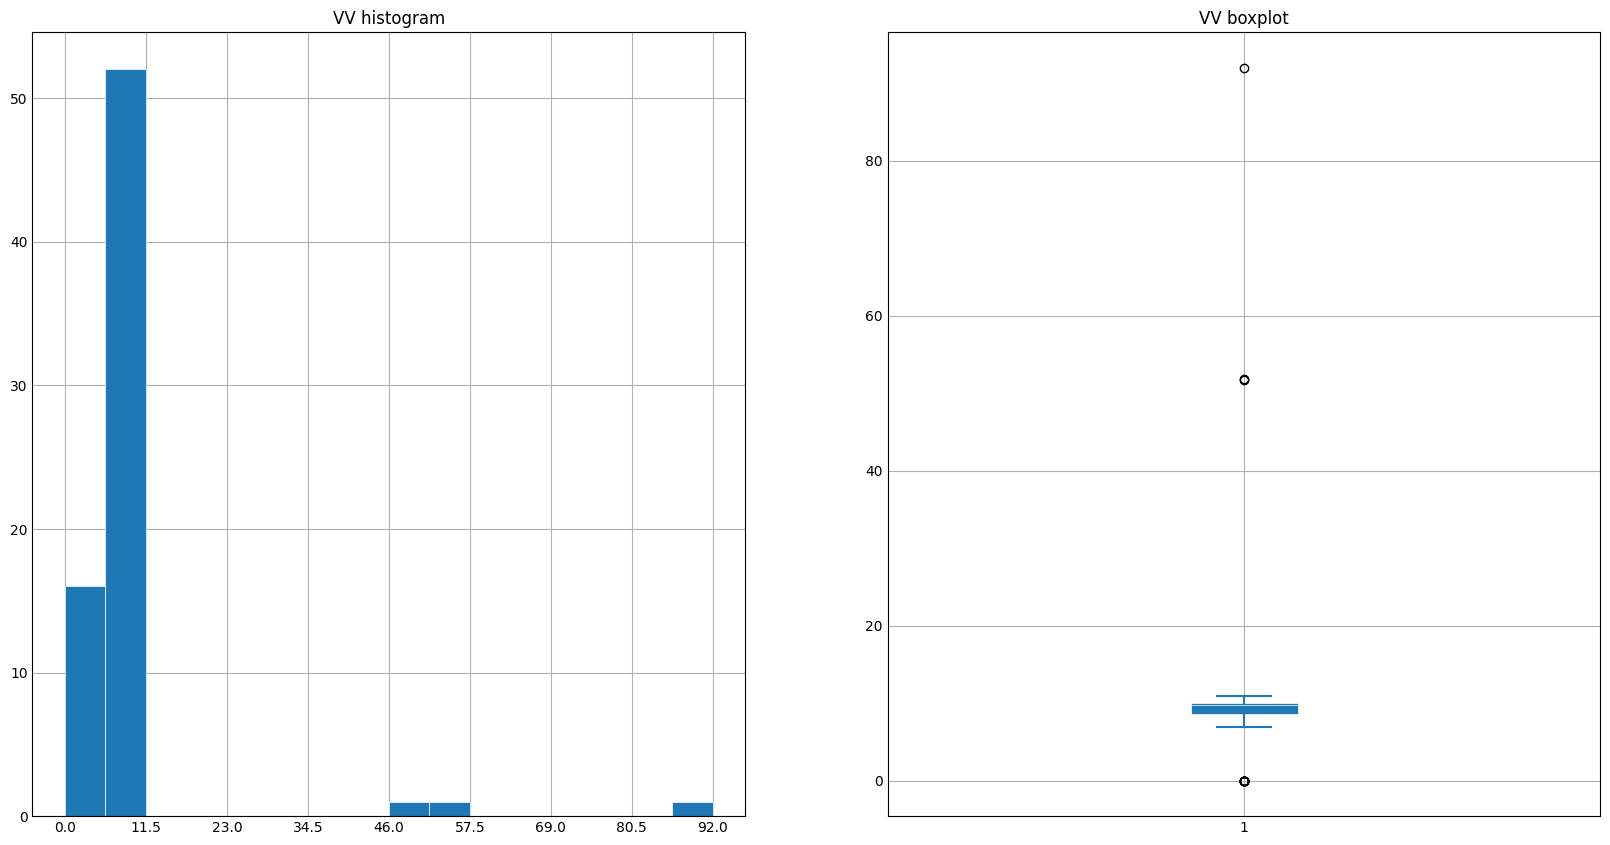

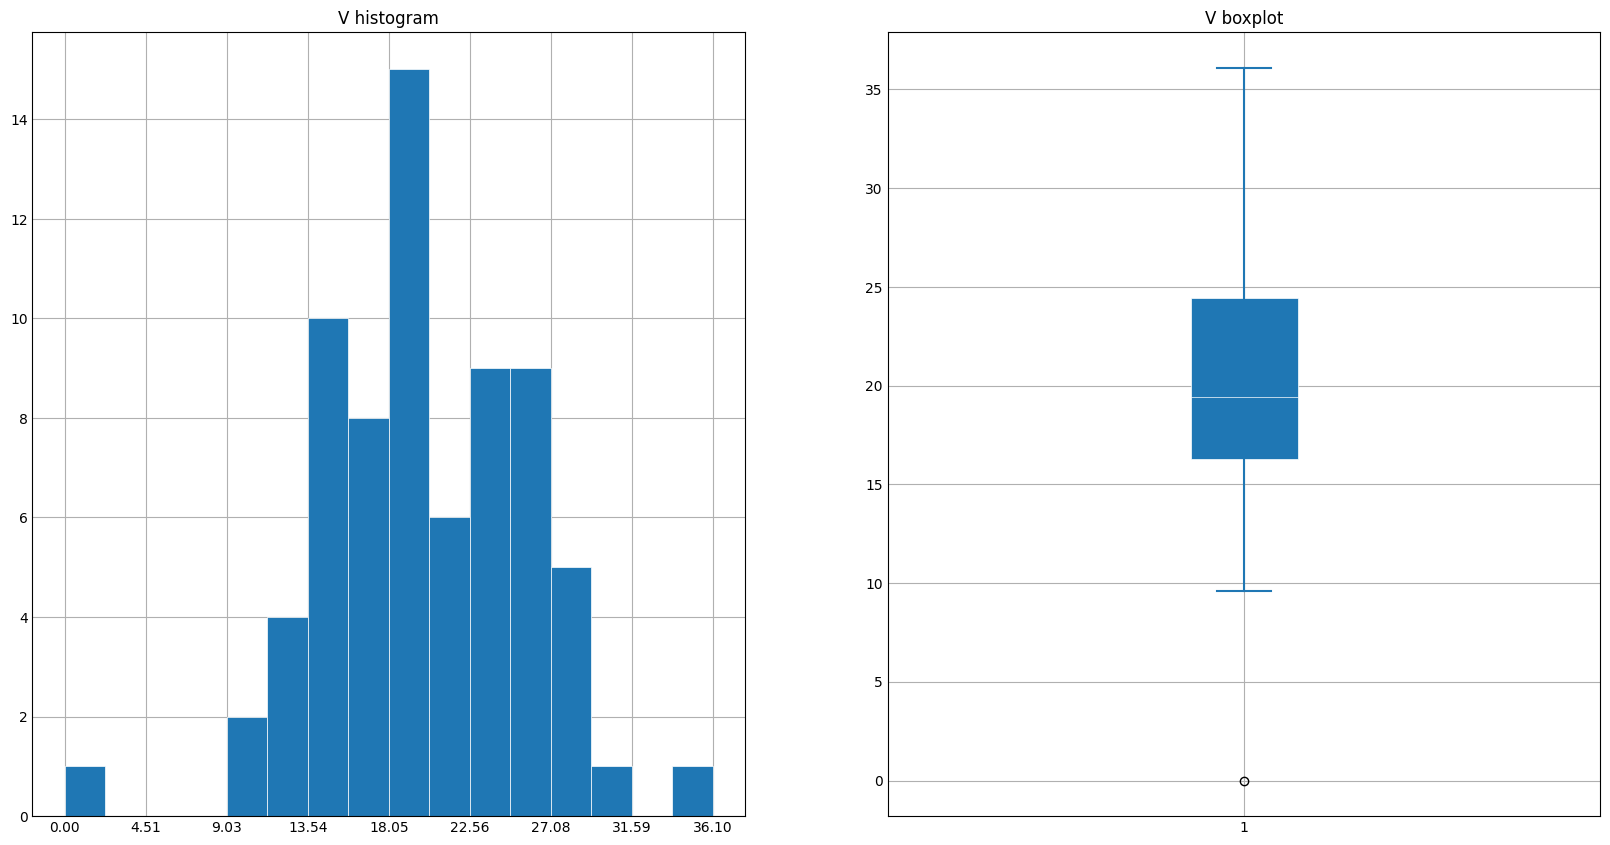

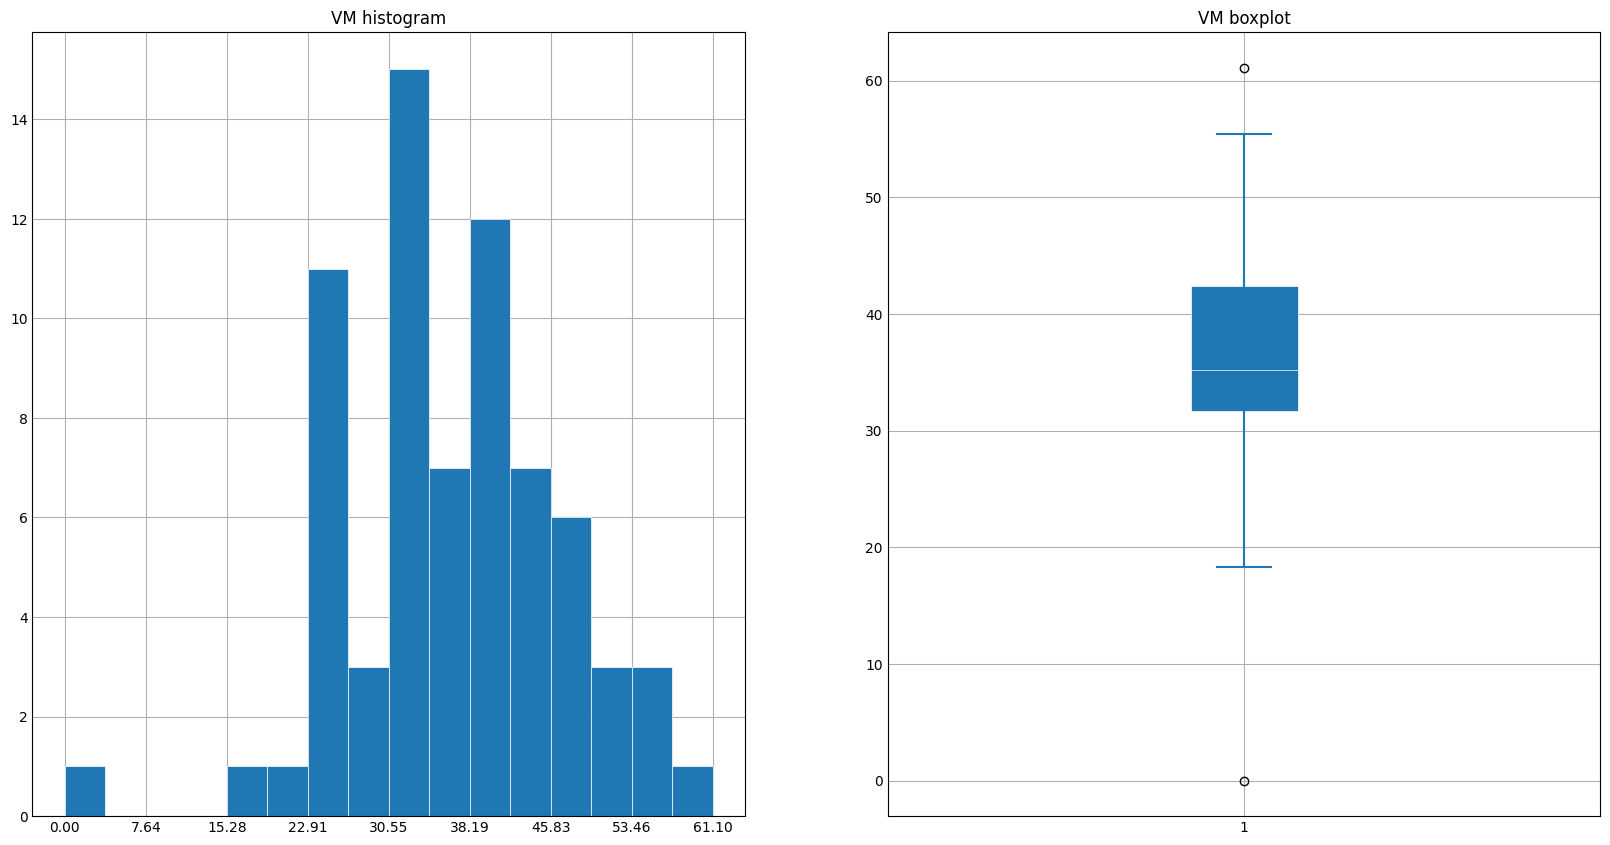

In [24]:
# Tipo1
Analise_condicional1 = pd.DataFrame(columns=['name', 'mean', 'standard_deviation', 'skewness'])

for i, predictor in enumerate(tipo1.columns):
    Analise_condicional1.loc[i] = [predictor, tipo1[predictor].mean(), tipo1[predictor].std(), tipo1[predictor].skew()]

    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo1[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo1[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
Analise_condicional1.index = Analise_condicional1.index + 1
Analise_condicional1